## DS 5500 - Forest Fires Project
Gopalika Sharma and Surya Menon

### Modeling - California Dataset
This file conducts modeling on the California wildfires data, subsetted from the US historical wildfires [dataset](https://enterprisecontentnew-usfs.hub.arcgis.com/datasets/e4d020cb51304d5194860d4464da7ba7_0/data?geometry=61.662%2C-2.200%2C54.279%2C76.163), from 1992-2015. 

#### REFERENCES:
- http://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26582553.pdf
- https://developers.arcgis.com/python/sample-notebooks/historical-wildfire-analysis/
- https://medium.com/@martin_47009/taiming-1-88-million-wildfires-e2595c43b769


In [1]:
# load intial packages
import pandas as pd
import numpy as np
from scipy import stats
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.stats import zscore
import plotly.express as px 
sns.set()

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

### Fire Size (Acres) Prediction

In [4]:
# load california data - with weather features (enhanced dataset)
cali = pd.read_csv('CA_DATA.csv')

print(cali.shape)
cali.head()

(53128, 35)


,ID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,...,AWND,DX90,EMXP,EMXT,PRCP,TAVG,TMAX,TMIN,NEAR_FID,NEAR_DIST
0,128764,38.900278,-120.002500,FED,FS-FIRESTAT,8525,WAGON,2000,2000/07/03 00:00:00+00,185,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,1759,1702.002813
1,128765,38.893889,-120.032222,FED,FS-FIRESTAT,8527,FALLEN,2000,2000/07/07 00:00:00+00,189,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,1450,844.446657
2,128766,38.900000,-119.983333,FED,FS-FIRESTAT,8514,HOSPITAL,2000,2000/05/02 00:00:00+00,123,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,99,1141.746990
3,128767,39.016944,-120.125000,FED,FS-FIRESTAT,8518,SIERRA,2000,2000/06/15 00:00:00+00,167,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,172,2029.504605
4,128768,38.851389,-119.968333,FED,FS-FIRESTAT,8528,ONEIDAS III,2000,2000/07/03 00:00:00+00,185,...,5.0,1.0,NaN,91.0,NaN,44.0,59.5,28.5,1868,4435.980601


In [66]:
# summary stats
cali.describe()

,ID,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,CONT_DOY,CONT_TIME,FIRE_SIZE,...,EMXP,EMXT,PRCP,TAVG,TMAX,TMIN,NEAR_FID,NEAR_DIST,MONTH,BURN_TIME
count,5.312800e+04,53128.000000,53128.000000,53128.000000,53128.000000,52688.000000,53128.000000,39796.000000,39332.000000,53128.000000,...,48265.000000,49780.000000,53128.000000,53128.000000,50518.000000,50746.000000,53128.000000,53128.000000,53128.000000,5.312800e+04
mean,1.106689e+06,37.408524,-120.022211,2009.932089,195.100456,1396.561418,6.524526,197.980023,1473.358156,121.128160,...,1.742583,104.190538,17.078403,60.486848,73.163932,47.689661,1587.319135,5968.522810,6.929246,-3.355625e+17
std,7.064809e+05,2.652477,2.138806,4.192461,71.952617,484.657664,4.242885,69.674419,489.553980,3134.429988,...,1.117584,10.617631,14.850249,9.178973,9.848898,9.545998,914.709291,6745.195268,2.365819,5.802187e+17
min,0.000000e+00,32.544965,-124.402883,2000.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.010000,...,0.050000,72.000000,0.080000,40.700000,47.900000,25.000000,2.000000,2.801478,1.000000,-1.451520e+18
25%,3.152108e+05,34.524931,-121.583037,2007.000000,154.000000,1131.000000,2.000000,158.000000,1213.000000,0.100000,...,0.910000,98.000000,5.700000,54.300000,66.900000,41.200000,779.000000,1809.364894,6.000000,-1.268676e+18
50%,1.511354e+06,37.867153,-120.437513,2011.000000,197.000000,1433.500000,7.000000,201.000000,1529.000000,0.110000,...,1.390000,106.000000,11.850000,61.200000,74.000000,48.600000,1592.000000,3727.095484,7.000000,1.000000e+00
75%,1.655824e+06,39.464099,-118.179100,2013.000000,241.000000,1721.000000,9.000000,241.000000,1805.000000,1.000000,...,2.370000,111.000000,25.380000,65.200000,78.400000,52.900000,2372.000000,7558.392468,8.000000,1.000000e+00
max,1.872304e+06,42.007800,-114.140200,2015.000000,366.000000,2359.000000,13.000000,366.000000,2359.000000,315578.800000,...,9.000000,125.000000,87.800000,77.600000,90.300000,68.400000,3150.000000,77738.566612,12.000000,3.205440e+16


<IPython.core.display.Javascript object>


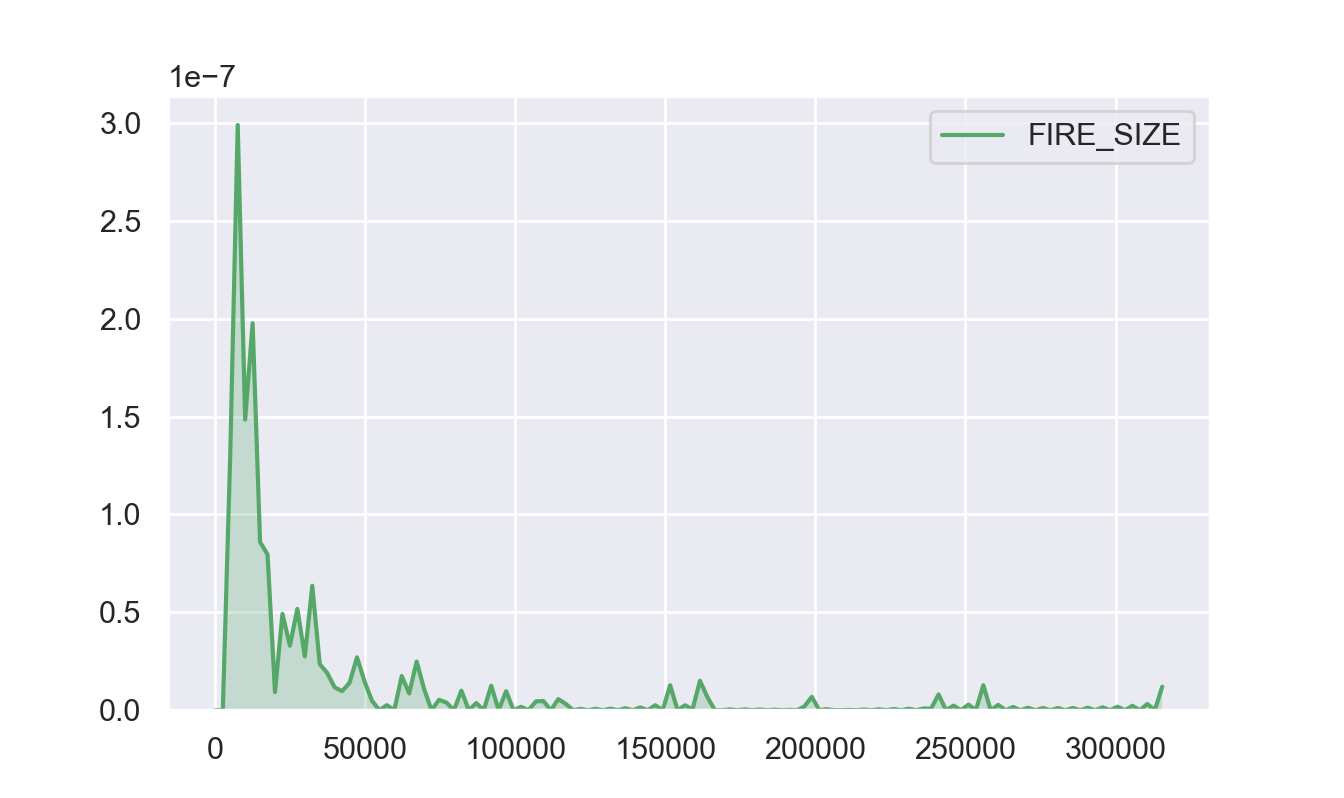

In [75]:
# distribution of target (fire size)
sns.kdeplot(cali['FIRE_SIZE'],color='g',shade=True);

In [2]:
# load original california data
cali_orig = pd.read_csv('cal_fire.csv')

print(cali_orig.shape)
cali_orig.head()

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning:

Columns (14,15,38,40) have mixed types. Specify dtype option on import or set low_memory=False.



(189550, 41)


,Unnamed: 0,X,Y,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,...,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,0,-121.005833,40.036944,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,...,0.10,A,40.036944,-121.005833,5,USFS,CA,63,63.0,Plumas
1,1,-120.404444,38.933056,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,...,0.25,A,38.933056,-120.404444,5,USFS,CA,61,61.0,Placer
2,2,-120.735556,38.984167,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,...,0.10,A,38.984167,-120.735556,13,STATE OR PRIVATE,CA,17,17.0,El Dorado
3,3,-119.913333,38.559167,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,...,0.10,A,38.559167,-119.913333,5,USFS,CA,3,3.0,Alpine
4,4,-119.933056,38.559167,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,...,0.10,A,38.559167,-119.933056,5,USFS,CA,3,3.0,Alpine


In [67]:
# summary stats - CA data without weather
cali_orig.describe()

,Unnamed: 0,X,Y,OBJECTID,FOD_ID,LOCAL_FIRE_REPORT_ID,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,FIPS_CODE
count,1.895500e+05,189550.000000,189550.000000,1.895500e+05,1.895500e+05,61933.000000,189550.000000,189550.000000,110217.000000,189550.000000,91908.000000,91198.000000,189550.000000,189550.000000,189550.000000,189550.000000,56221.000000
mean,9.353982e+05,-120.182292,37.434167,9.353992e+05,5.667452e+07,45822.301358,2003.118275,201.594571,1383.752742,5.690725,203.607727,1474.324042,67.242725,37.434167,-120.182292,10.767038,56.633518
std,5.864817e+05,2.155615,2.591567,5.864817e+05,1.060565e+08,137507.656546,7.007634,65.936299,490.324275,3.677568,65.127623,508.483440,2029.960435,2.591567,2.155615,4.402412,30.041381
min,0.000000e+00,-124.402883,32.537406,1.000000e+00,1.000000e+00,1.000000,1992.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.001000,32.537406,-124.402883,0.000000,1.000000
25%,3.112162e+05,-121.721944,35.177688,3.112172e+05,3.174202e+05,31.000000,1997.000000,164.000000,1115.000000,2.000000,169.000000,1200.000000,0.100000,35.177688,-121.721944,6.000000,35.000000
50%,1.096220e+06,-120.530316,37.565062,1.096222e+06,1.335048e+06,69.000000,2003.000000,202.000000,1428.000000,5.000000,206.000000,1530.000000,0.250000,37.565062,-120.530316,14.000000,61.000000
75%,1.143608e+06,-118.595503,39.475208,1.143609e+06,1.393693e+06,157.000000,2009.000000,245.000000,1715.000000,9.000000,246.000000,1810.000000,1.000000,39.475208,-118.595503,14.000000,73.000000
max,1.880464e+06,-114.125800,42.051667,1.880465e+06,3.003484e+08,600489.000000,2015.000000,366.000000,2359.000000,13.000000,366.000000,2359.000000,315578.800000,42.051667,-114.125800,15.000000,115.000000


<IPython.core.display.Javascript object>


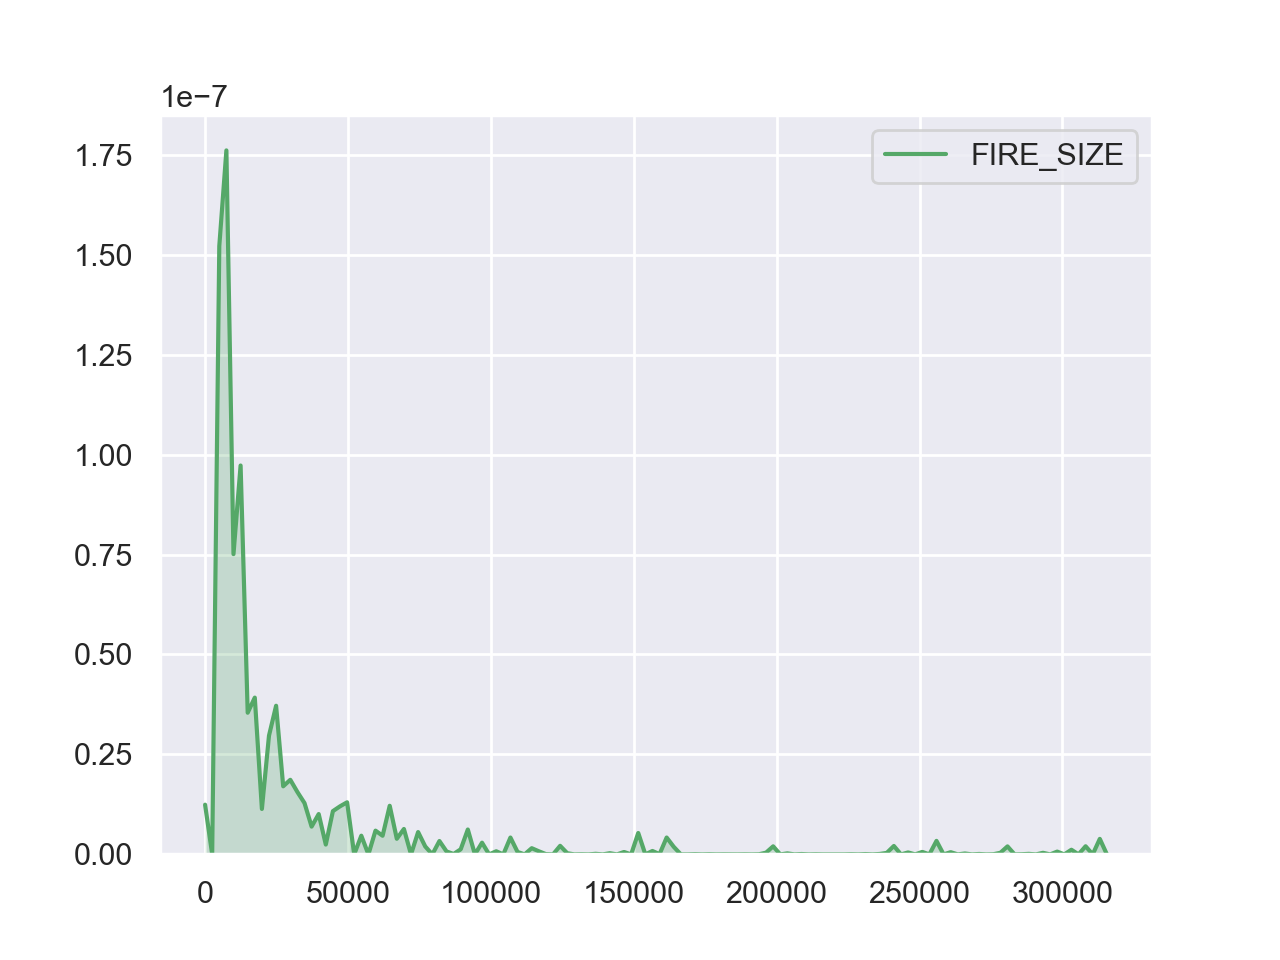

In [76]:
# fire size distribution - original data
sns.kdeplot(cali_orig['FIRE_SIZE'],color='g',shade=True);

In [87]:
# number of small fires in weather dataset
len(cali[cali['FIRE_SIZE']<1])

37145

In [78]:
# smal fire instances in original data
len(cali_orig[cali_orig['FIRE_SIZE']<1])

123759

In [13]:
# numeric features to ignore in correlation
cor_drop = ['ID','FIRE_CODE', 'DISCOVERY_DATE', 'DISCOVERY_TIME', 
            'STAT_CAUSE_CODE','CONT_DATE', 'CONT_DOY', 'CONT_TIME','OWNER_CODE', 'FIPS_CODE',
           'DATE', 'NEAR_FID']

<IPython.core.display.Javascript object>


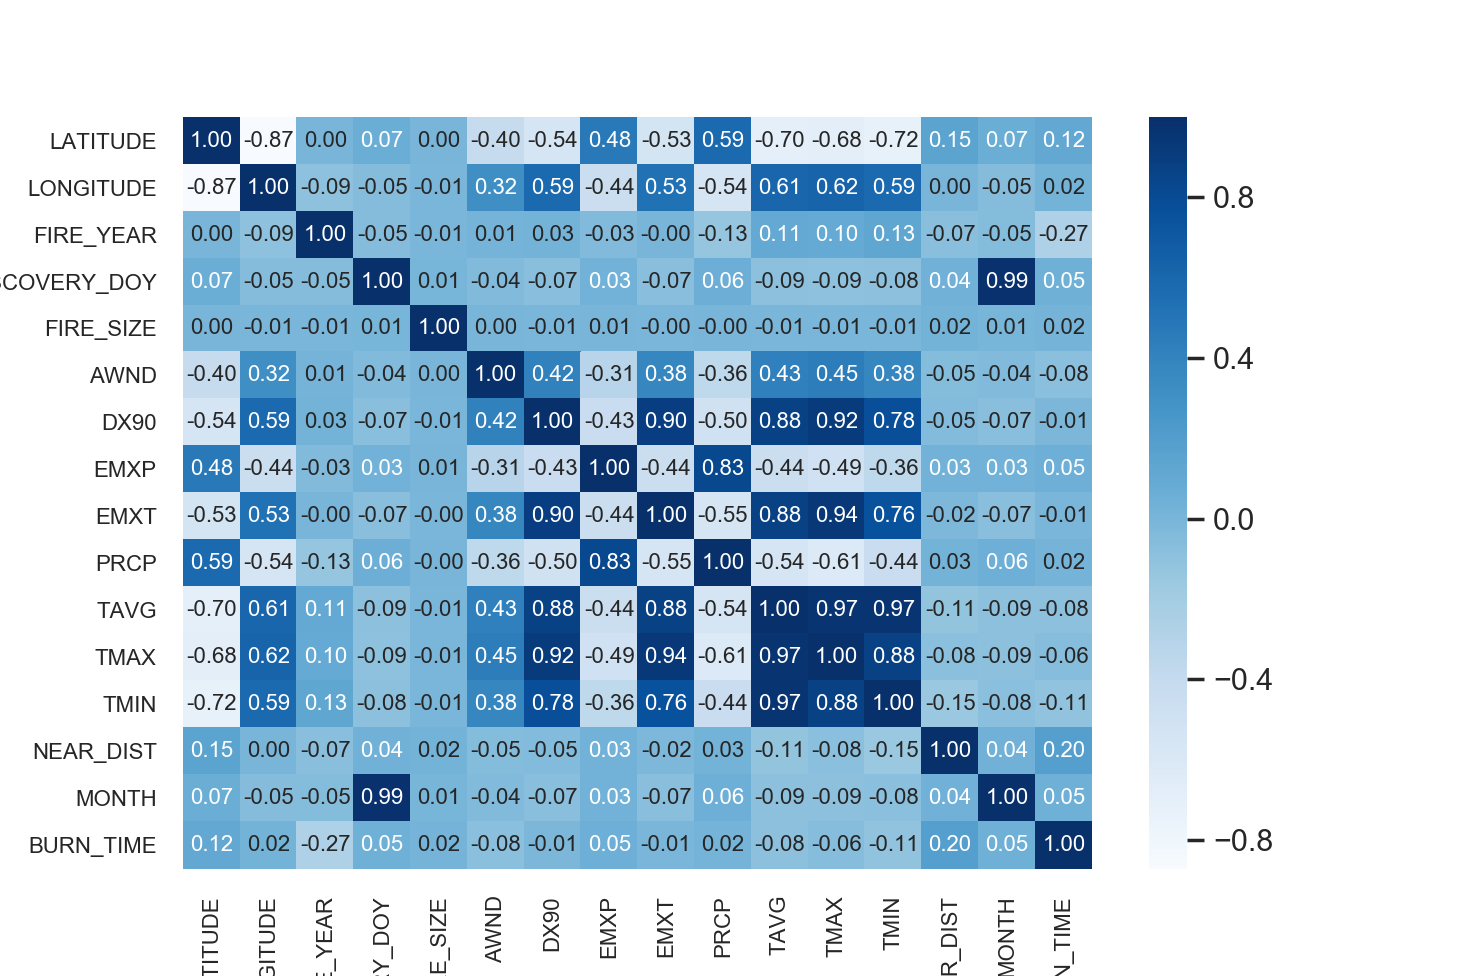

In [14]:
# correlation - not much correlated with fire size
sns.heatmap(cali.drop(cor_drop, axis=1).corr(), fmt='.2f', annot=True, annot_kws={"fontsize":8}, cmap="Blues")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

#### We don't see a lot of correlation between any of the features and `FIRE_SIZE`

In [31]:
# explore date fields
cali[['DISCOVERY_DATE', 'CONT_DATE']].head()

,DISCOVERY_DATE,CONT_DATE
0,2000/07/03 00:00:00+00,2000/07/03 00:00:00+00
1,2000/07/07 00:00:00+00,2000/07/07 00:00:00+00
2,2000/05/02 00:00:00+00,2000/05/02 00:00:00+00
3,2000/06/15 00:00:00+00,2000/06/15 00:00:00+00
4,2000/07/03 00:00:00+00,2000/07/03 00:00:00+00


### Preprocessing and Feature Extraction

In [5]:
# new possible features - based on date
cali['DATE'] = pd.to_datetime(cali['DISCOVERY_DATE'])
cali['MONTH'] = cali['DATE'].dt.month
cali['BURN_TIME'] = (pd.to_datetime(cali['CONT_DATE']) - cali['DATE']).astype(int)+1

cali.head()

,ID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,...,EMXP,EMXT,PRCP,TAVG,TMAX,TMIN,NEAR_FID,NEAR_DIST,MONTH,BURN_TIME
0,128764,38.900278,-120.002500,FED,FS-FIRESTAT,8525,WAGON,2000,2000/07/03 00:00:00+00,185,...,NaN,91.0,NaN,44.0,59.5,28.5,1759,1702.002813,7,1
1,128765,38.893889,-120.032222,FED,FS-FIRESTAT,8527,FALLEN,2000,2000/07/07 00:00:00+00,189,...,NaN,91.0,NaN,44.0,59.5,28.5,1450,844.446657,7,1
2,128766,38.900000,-119.983333,FED,FS-FIRESTAT,8514,HOSPITAL,2000,2000/05/02 00:00:00+00,123,...,NaN,91.0,NaN,44.0,59.5,28.5,99,1141.746990,5,1
3,128767,39.016944,-120.125000,FED,FS-FIRESTAT,8518,SIERRA,2000,2000/06/15 00:00:00+00,167,...,NaN,91.0,NaN,44.0,59.5,28.5,172,2029.504605,6,1
4,128768,38.851389,-119.968333,FED,FS-FIRESTAT,8528,ONEIDAS III,2000,2000/07/03 00:00:00+00,185,...,NaN,91.0,NaN,44.0,59.5,28.5,1868,4435.980601,7,1


In [6]:
 # impute PRCP, AWND, TAVG with median values
cali['PRCP'] = cali['PRCP'].fillna(cali['PRCP'].median())
cali['AWND'] = cali['AWND'].fillna(cali['AWND'].median())
cali['TAVG'] = cali['TAVG'].fillna(cali['TAVG'].median())

# DX90 - set null to 0
cali['DX90'] = cali['DX90'].fillna(cali['DX90'].median())

cali.isnull().sum()

ID                        0
LATITUDE                  0
LONGITUDE                 0
SOURCE_SYSTEM_TYPE        0
SOURCE_SYSTEM             0
FIRE_CODE             24978
FIRE_NAME              8604
FIRE_YEAR                 0
DISCOVERY_DATE            0
DISCOVERY_DOY             0
DISCOVERY_TIME          440
STAT_CAUSE_CODE           0
STAT_CAUSE_DESCR          0
CONT_DATE                 0
CONT_DOY              13332
CONT_TIME             13796
FIRE_SIZE                 0
FIRE_SIZE_CLASS           0
OWNER_CODE                0
OWNER_DESCR               0
STATE                     0
FIPS_CODE                 0
FIPS_NAME                 0
County                    0
DATE                      0
AWND                      0
DX90                      0
EMXP                   4863
EMXT                   3348
PRCP                      0
TAVG                      0
TMAX                   2610
TMIN                   2382
NEAR_FID                  0
NEAR_DIST                 0
MONTH               

In [26]:
# features to drop
drop_vars = ['ID','SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'FIRE_CODE', 'DISCOVERY_DATE',
             'DISCOVERY_TIME','STAT_CAUSE_CODE','OWNER_CODE', 'FIPS_CODE', 'FIPS_NAME', 'DATE',
            'CONT_DATE', 'CONT_DOY', 'CONT_TIME','FIRE_SIZE_CLASS', 'OWNER_CODE', 'OWNER_DESCR', 
             'STATE', 'FIPS_CODE','NEAR_FID', 'County', 'MONTH','DISCOVERY_DOY', 'FIRE_NAME', 'EMXP', 'EMXT', 'TMIN', 'TMAX']

In [27]:
# drop features for modeling
cali_drop = cali.drop(columns=drop_vars, axis=1)
cali_drop.columns

Index(['LATITUDE', 'LONGITUDE', 'FIRE_YEAR', 'STAT_CAUSE_DESCR', 'FIRE_SIZE',
       'AWND', 'DX90', 'PRCP', 'TAVG', 'NEAR_DIST', 'BURN_TIME'],
      dtype='object')

In [28]:
# encoding month and cause
# cali_mod = pd.get_dummies(cali_drop,columns=['MONTH', 'STAT_CAUSE_DESCR'],drop_first=True)
cali_mod = pd.get_dummies(cali_drop,columns=['STAT_CAUSE_DESCR'],drop_first=True)

In [10]:
# preview encoding
cali_mod.head()

,LATITUDE,LONGITUDE,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,AWND,DX90,PRCP,TAVG,NEAR_DIST,...,STAT_CAUSE_DESCR_Debris Burning,STAT_CAUSE_DESCR_Equipment Use,STAT_CAUSE_DESCR_Fireworks,STAT_CAUSE_DESCR_Lightning,STAT_CAUSE_DESCR_Miscellaneous,STAT_CAUSE_DESCR_Missing/Undefined,STAT_CAUSE_DESCR_Powerline,STAT_CAUSE_DESCR_Railroad,STAT_CAUSE_DESCR_Smoking,STAT_CAUSE_DESCR_Structure
0,38.900278,-120.002500,2000,185,0.1,5.0,1.0,11.85,44.0,1702.002813,...,0,0,0,0,0,0,0,0,0,0
1,38.893889,-120.032222,2000,189,0.1,5.0,1.0,11.85,44.0,844.446657,...,0,0,0,0,0,0,0,0,0,0
2,38.900000,-119.983333,2000,123,0.1,5.0,1.0,11.85,44.0,1141.746990,...,0,0,0,0,0,0,0,0,0,0
3,39.016944,-120.125000,2000,167,1.0,5.0,1.0,11.85,44.0,2029.504605,...,0,0,0,0,0,0,0,0,1,0
4,38.851389,-119.968333,2000,185,0.1,5.0,1.0,11.85,44.0,4435.980601,...,0,0,0,0,0,0,0,0,0,0


In [286]:
# split data into train/test 
X,y = cali_mod.drop(columns=['FIRE_SIZE']), cali_mod['FIRE_SIZE']

trainX, testX, trainY, testY = train_test_split(X,y, train_size=0.8, random_state=42, shuffle=True)

In [59]:
trainX.shape

(42502, 32)

In [60]:
testX.shape

(10626, 32)

In [30]:
# scale dataset
scaler_ca = StandardScaler()
scaler_ca.fit(trainX)

trainX_scale = scaler_ca.transform(trainX)
testX_scale = scaler_ca.transform(testX)

In [40]:
# decide whether to log transform output
cali_log = cali.copy()
cali_log['SIZE_LOG'] = np.log(cali_log['FIRE_SIZE'])

<IPython.core.display.Javascript object>


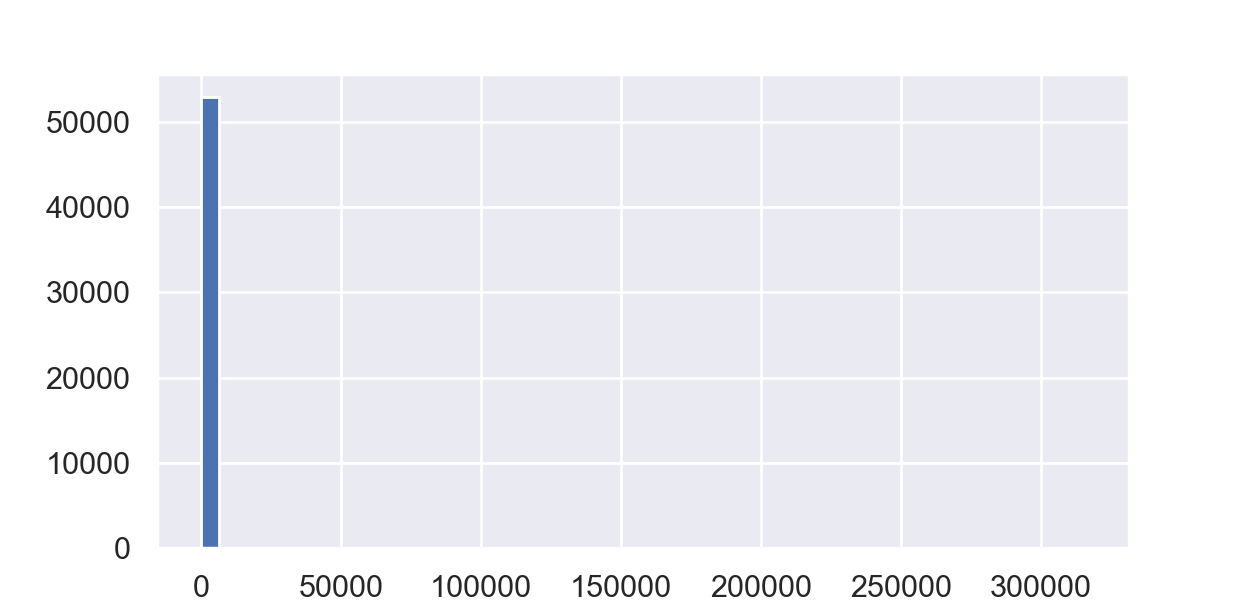

In [42]:
cali_log['FIRE_SIZE'].hist(bins=50);

<IPython.core.display.Javascript object>


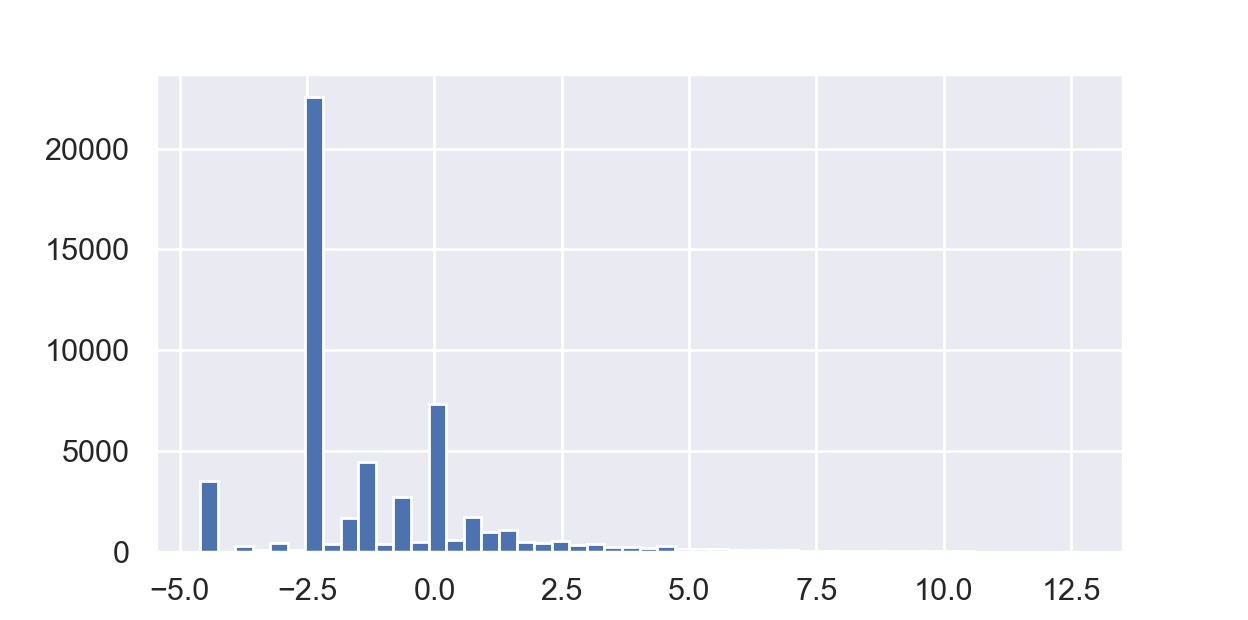

In [41]:
cali_log['SIZE_LOG'].hist(bins=50);

<IPython.core.display.Javascript object>


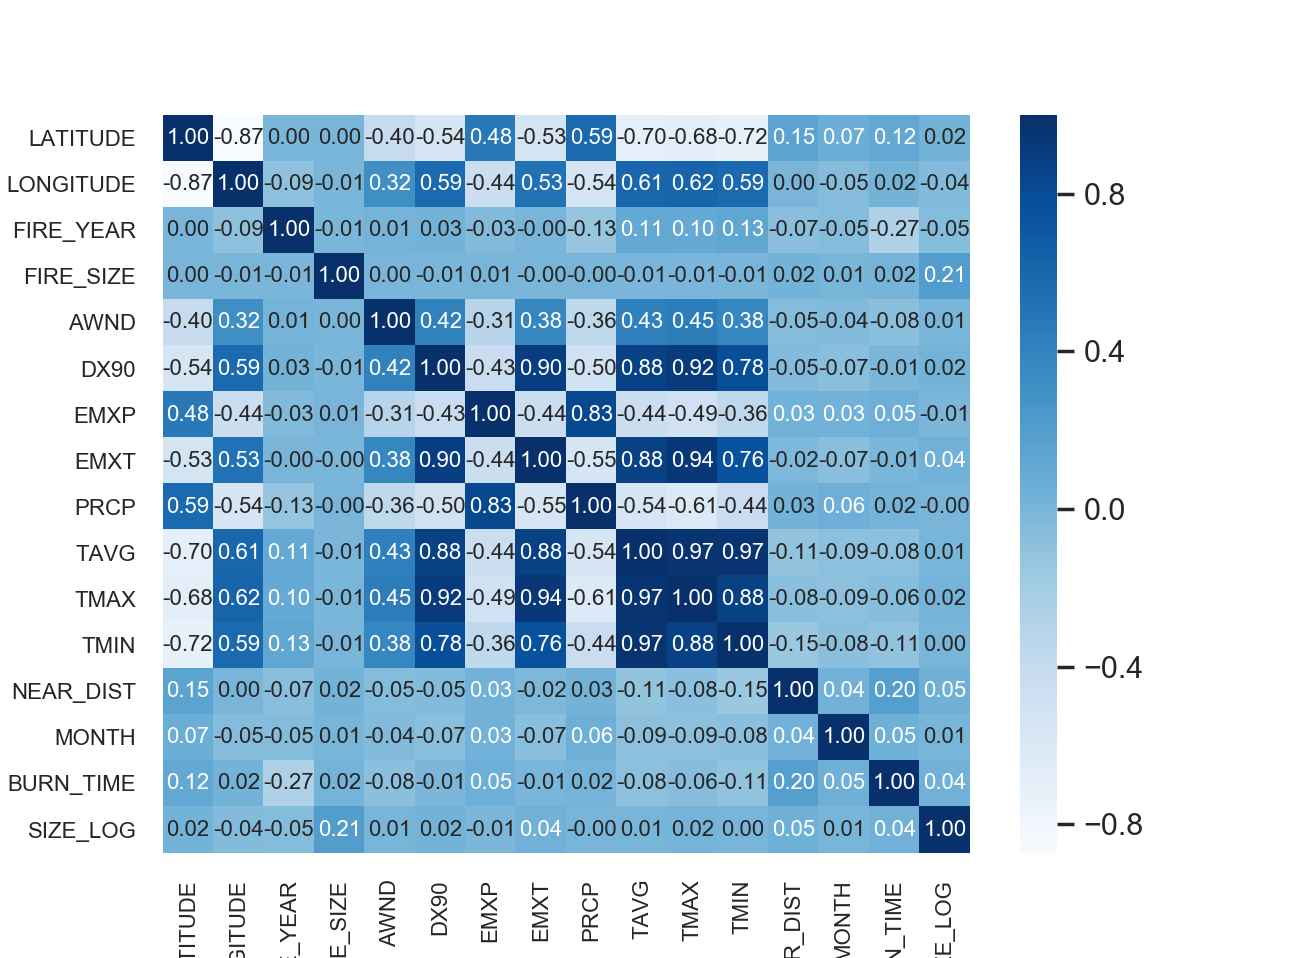

In [43]:
# not huge justification to log transform
sns.heatmap(cali_log.drop(cor_drop, axis=1).corr(), fmt='.2f', annot=True, annot_kws={"fontsize":8}, cmap="Blues")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

#### We explored the possibility of log transforming the output, but exploring alongside other features does not provide much justification at this time

In [45]:
# log transform output
trainY_log = np.log(trainY)
testY_log = np.log(testY)

In [15]:
# function to train model
def fit_model2(model, X, y):
    model.fit(X, y)
    preds = model.predict(X)
    print('Train MAE:', mean_absolute_error(y, preds))
    # reduce number of folds
    cv_scores = cross_val_score(model,X,y, scoring='neg_mean_absolute_error', cv=5)
    print('Average CV MAE:', cv_scores.mean()*-1)

#### Linear Regression
We don't see overfitting but we observe a high MAE value - with scaled and non-scaled data

In [33]:
# LR - baseline - without scaling
ca_lreg_no_scale = LinearRegression()
fit_model2(ca_lreg_no_scale, trainX, trainY)

Train MAE: 232.25826954300055
Average CV MAE: 232.54015832801778


In [31]:
# LR - baseline
ca_lreg = LinearRegression()
fit_model2(ca_lreg, trainX_scale, trainY)

Train MAE: 237.91578334912194
Average CV MAE: 241.22304805503586


In [359]:
# test without scale
lr_preds_test_ca_no_scale = ca_lreg_no_scale.predict(testX)
print('Test MAE:', mean_absolute_error(testY, lr_preds_test_ca_no_scale))

Test MAE: 230.90265444621772


#### Decision Tree Regressor
We observe high overfitting - look at Random Forest next

In [60]:
# dt
cali_dt = DecisionTreeRegressor()
fit_model2(cali_dt, trainX_scale, trainY)

Train MAE: 0.058725318621794094
Average CV MAE: 188.30183674446167


#### Random Forest Regressor
We still see high overfitting (possibly due to the number of small fire instances, lack of generalizability) or the weather features are not granular enough. Even with some hyperparameter tuning (max depth, estimators) we still see overfitting. But the MAE is lower than linear regression. 

Feature importance plotting confirms that the weather features are relevant but perhaps not detailed enough for this prediction (average yearly values, versus monthly averages would probably be more accurate in terms of conditions).

In [34]:
# RF without scaling
ca_rf_no_scale = RandomForestRegressor()
fit_model2(ca_rf_no_scale, trainX, trainY)

Train MAE: 67.36643174557601
Average CV MAE: 187.76008539093328


In [36]:
# test without scale
rf_preds_test_ca_no_scale = ca_rf_no_scale.predict(testX)
print('Test MAE:', mean_absolute_error(testY, rf_preds_test_ca_no_scale))

Test MAE: 183.6553195326611


<IPython.core.display.Javascript object>


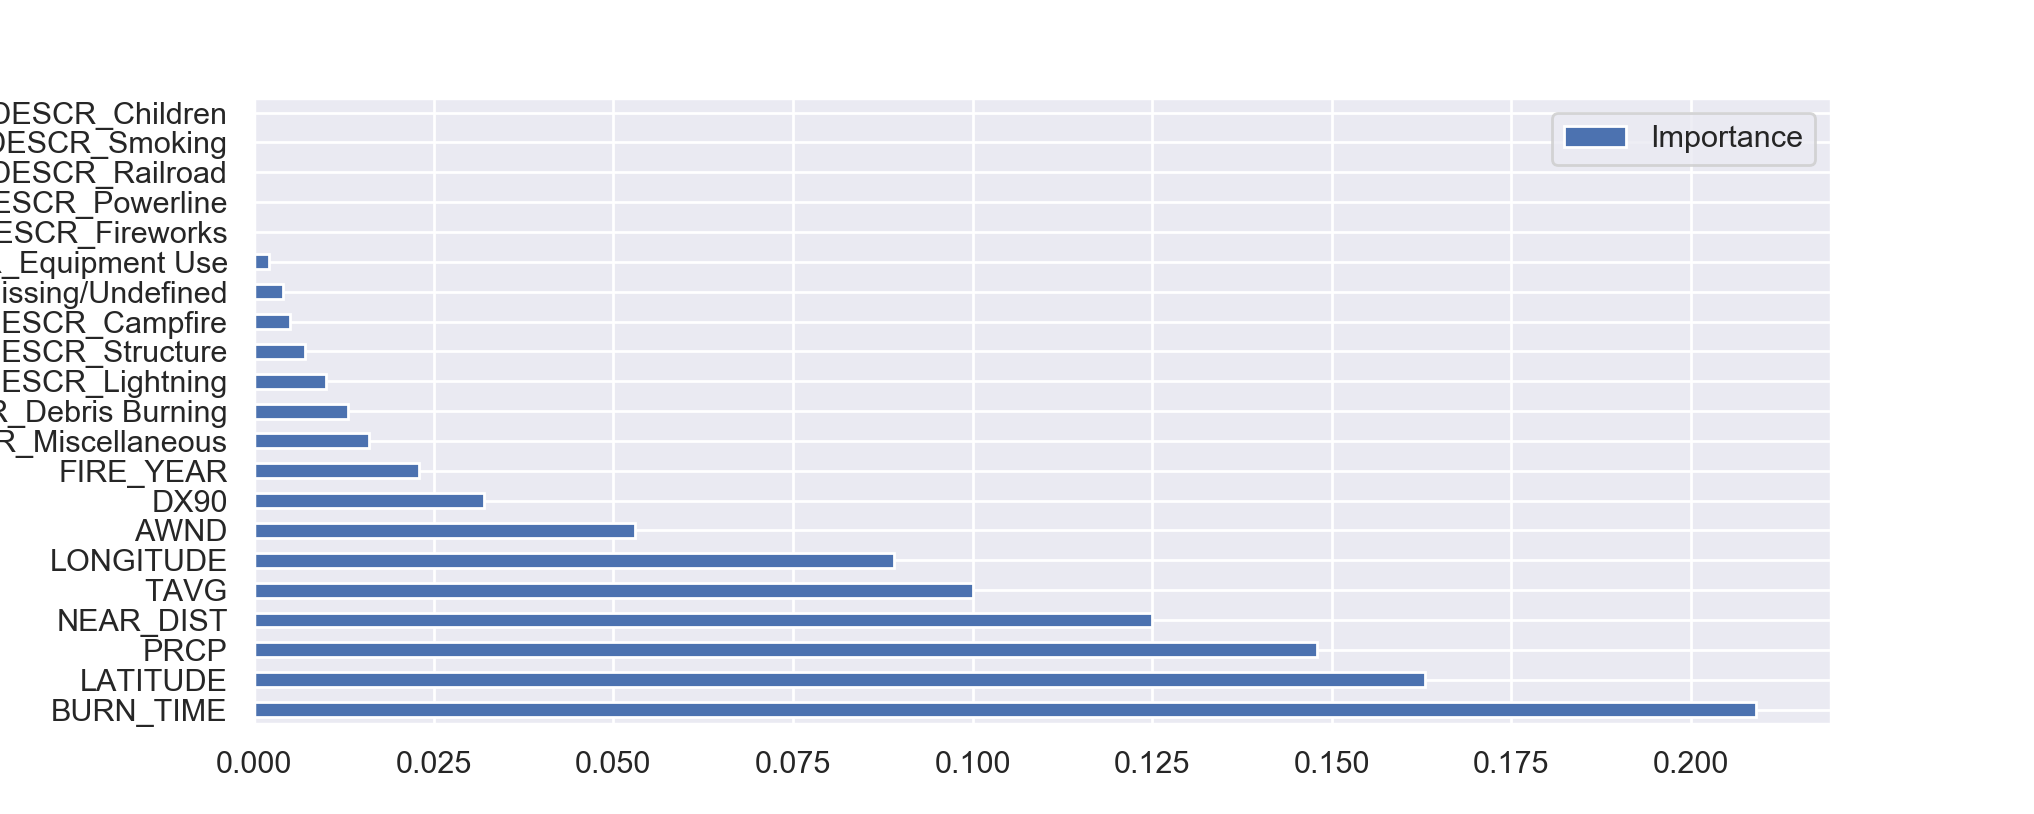

In [41]:
# feature importance
rf_fi_no_scale = pd.DataFrame({'Features':trainX.columns,'Importance':np.round(ca_rf_no_scale.feature_importances_,3)}).sort_values('Importance',ascending=False)
rf_fi_no_scale.plot(x='Features',y='Importance',kind='barh');

In [136]:
top_feats = ['LATITUDE', 'LONGITUDE', 'FIRE_YEAR', 'AWND', 'DX90', 'PRCP', 'TAVG','NEAR_DIST', 'BURN_TIME']

In [38]:
# random forest - scaled
ca_rf = RandomForestRegressor()
fit_model2(ca_rf, trainX_scale, trainY)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Train MAE: 73.12411973493857
Average CV MAE: 181.0940889678624


In [211]:
# tuning RF - check estimators, max features, depth
from sklearn.model_selection import RandomizedSearchCV

cali_rf_params = {'n_estimators': [10, 50, 70, 100], 
                  'max_features': [5], 
                  'max_depth': [50, 60]}

rf_cali_search = RandomizedSearchCV(RandomForestRegressor(random_state=2), param_distributions=cali_rf_params,
                                   cv=3, random_state=2, scoring='neg_mean_absolute_error')
rf_cali_search.fit(trainX, trainY)

print("Best Hyperparameters:",rf_cali_search.best_params_)
print("Best CV score is {}".format(rf_cali_search.best_score_*-1))

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning:

The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.



Best Hyperparameters: {'n_estimators': 70, 'max_features': 5, 'max_depth': 50}
Best CV score is 172.19305079700777


In [219]:
# fit on scale, unscale, top features - overfitting despite tuning
ca_rf1 = RandomForestRegressor(n_estimators=70, max_depth=50, max_features=5,random_state=2)
ca_rf1.fit(trainX, trainY)
#ca_rf1.fit(trainX_scale, trainY)
#rf_preds1 = ca_rf1.predict(trainX[top_feats])

# training score
rf_preds1 = ca_rf1.predict(trainX)
#rf_preds1 = ca_rf1.predict(trainX[top_feats])
#rf_preds1 = ca_rf1.predict(trainX_scale)

print('Train MAE:', mean_absolute_error(trainY, rf_preds1))

Train MAE: 64.521785926125


In [220]:
# RF test
rf_preds_test_ca1 = ca_rf1.predict(testX)
#rf_preds_test_ca1 = ca_rf1.predict(testX[top_feats])
#rf_preds_test_ca1 = ca_rf1.predict(testX_scale)
print('Test MAE:', mean_absolute_error(testY, rf_preds_test_ca1))

Test MAE: 161.36388676505638


#### SVM 
We were able to fit SVM with a linear kernel (using LinearSVR, otherwise does not finish training due to dataset size) and get no overfitting and a lower MAE than previous models. The error is still high but we see improved performance compared to other models. We see that a combination of causes and weather conditions have the highest weight

In [107]:
# SVM - linear
from sklearn.svm import LinearSVR
cali_svm_lin = LinearSVR()
fit_model2(cali_svm_lin, trainX_scale, trainY)

Train MAE: 121.19284106761917
Average CV MAE: 121.19459404991264


In [108]:
# SVM - linear - test
svm_lin_preds = cali_svm_lin.predict(testX_scale)
print('Test MAE:', mean_absolute_error(testY, svm_lin_preds))

Test MAE: 120.4198172988075


In [226]:
cali_svm_lin.coef_

array([-0.03652231, -0.08384751, -0.00202329, -0.01546715,  0.02226148,
       -0.0024987 ,  0.0051078 ,  0.01001785, -0.00626914, -0.00797009,
        0.00652068, -0.00387041, -0.00728666,  0.03914581, -0.01617961,
       -0.01750446, -0.0031793 , -0.00325871, -0.00514371, -0.00896733,
        0.0049055 ])

<IPython.core.display.Javascript object>


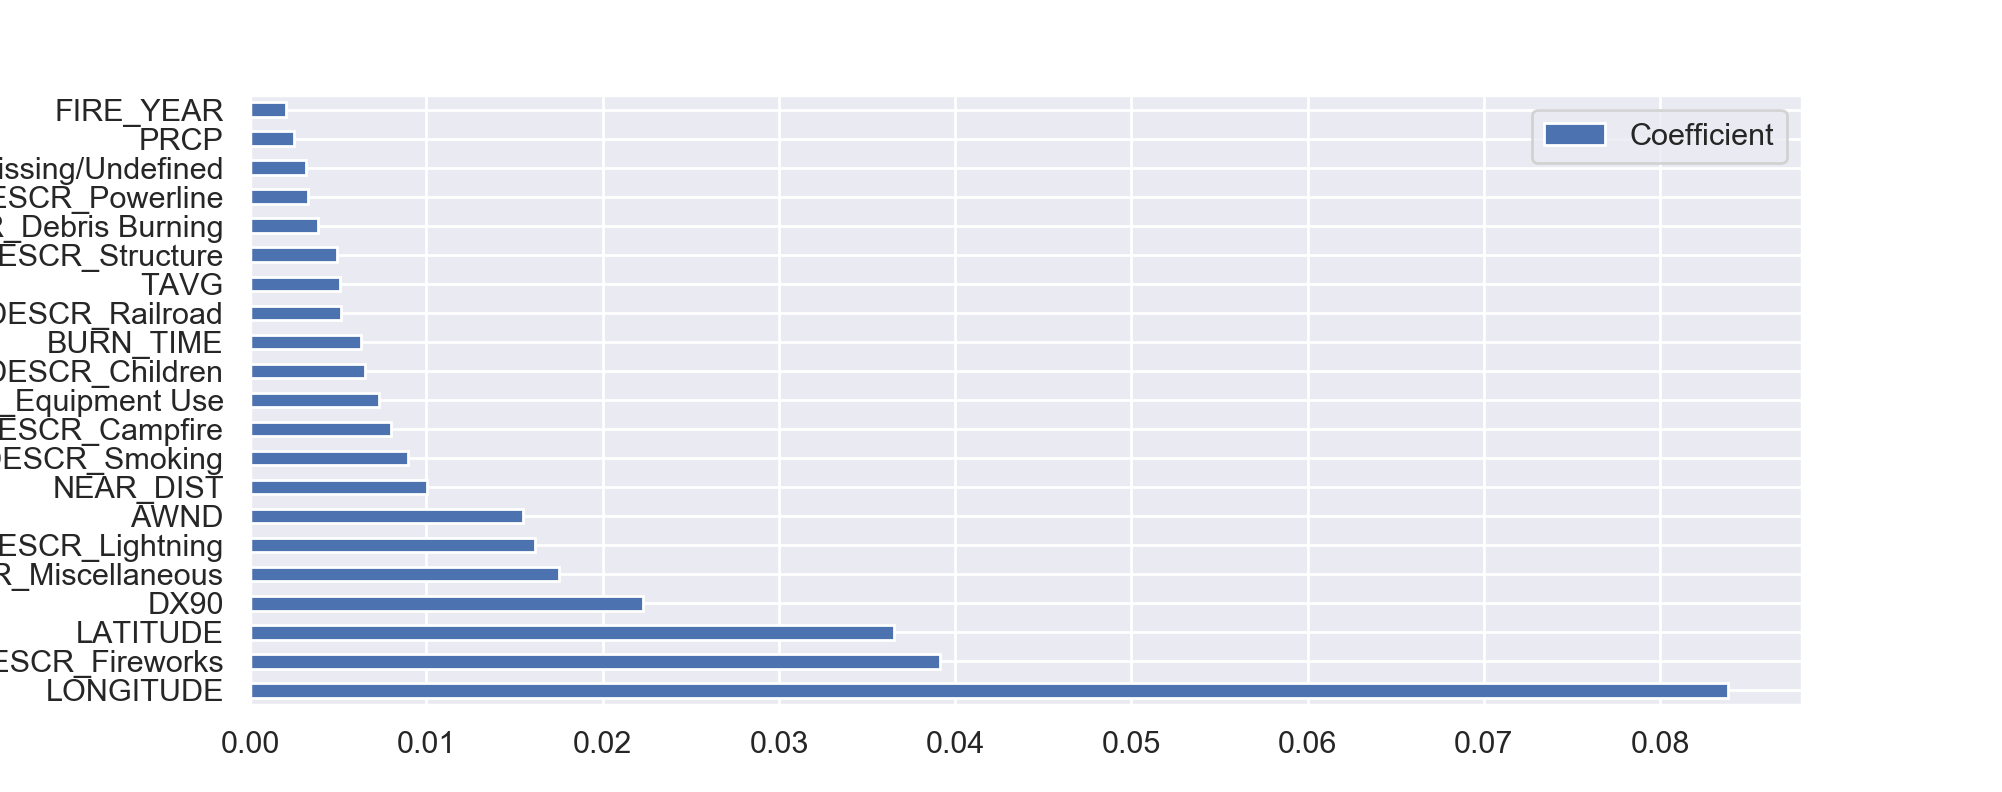

In [228]:
# most contributing SVM coefficients
svm_feature_import = pd.DataFrame({'Features':trainX.columns,'Coefficient':abs(cali_svm_lin.coef_)}).sort_values('Coefficient',ascending=False)
svm_feature_import.plot(x='Features',y='Coefficient',kind='barh');

In [115]:
# SVM - try subset to run rbf - not much better than linear
cali_svm_rbf = svm.SVR(kernel='rbf', degree=3, gamma='auto')
fit_model2(cali_svm_rbf, trainX_scale[0:10000,:], trainY[0:10000])
svm_rbf_preds = cali_svm_rbf.predict(testX_scale)
print('Test MAE:', mean_absolute_error(testY, svm_rbf_preds))

Train MAE: 132.2538409039879
Average CV MAE: 132.27252310887894
Test MAE: 120.41742645435313


#### XGBoost
Similar to RF, we see high overfitting

In [117]:
# XGB
cali_xgb = xgb.XGBRegressor()
fit_model2(cali_xgb, trainX_scale, trainY)

Train MAE: 31.62602362522691
Average CV MAE: 183.8970459785928


#### Minimal testing on original data (without weather features)
We wanted to see if we could get any differences when looking at the original dataset, without any of the the enhancements. We find improved scores compared to our previous models, which adds weight that the weather related data we added is not granular enough to help with the prediction

In [68]:
# original data - without weather features
cali_orig['DATE'] = pd.to_datetime(cali_orig['DISCOVERY_DATE'])
cali_orig['BURN_TIME'] = (pd.to_datetime(cali_orig['CONT_DATE']) - cali_orig['DATE']).astype(int)+1

Xorig,yorig = cali_orig[['BURN_TIME', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE',
       'LATITUDE', 'LONGITUDE']], cali_orig['FIRE_SIZE']

trainX1, testX1, trainY1, testY1 = train_test_split(Xorig,yorig, train_size=0.8, random_state=42, shuffle=True)

In [69]:
# scale
sc2 = StandardScaler()
sc2.fit(trainX1)

trainX_scale1 = sc2.transform(trainX1)
testX_scale1 = sc2.transform(testX1)

In [70]:
# linear regression
fit_model2(LinearRegression(), trainX1, trainY1)

Train MAE: 130.6193666172275
Average CV MAE: 130.64719717841194


In [72]:
# RF - original data
fit_model2(RandomForestRegressor(), trainX1, trainY1)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Train MAE: 40.3695216327156
Average CV MAE: 108.598136581612


In [118]:
# XGB
cali_xgb_orig = xgb.XGBRegressor()
fit_model2(cali_xgb_orig, trainX1, trainY1)

Train MAE: 39.66202875430035
Average CV MAE: 104.37224833216283


In [73]:
# try new california data on original data features
X1,y1 = cali[['BURN_TIME', 'DISCOVERY_DOY', 'STAT_CAUSE_CODE',
       'LATITUDE', 'LONGITUDE']], cali['FIRE_SIZE']

trainX2, testX2, trainY2, testY2 = train_test_split(X1,y1, train_size=0.8, random_state=42, shuffle=True)

In [74]:
# not much improvement - not enough data?
fit_model2(LinearRegression(), trainX2, trainY2)

Train MAE: 232.88723565425676
Average CV MAE: 232.88441089479835


In [119]:
# try RF
fit_model2(RandomForestRegressor(), trainX2, trainY2)

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Train MAE: 76.77862797376466
Average CV MAE: 186.57629282322358


### CA Fires - Fire Cause Prediction

#### Multi-class
We first explored if we could predict the fire cause (out of 13 classes) briefly

In [289]:
# import some classifier packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate

In [281]:
# create labels for causes
cali['cause_label'] = cali['STAT_CAUSE_CODE']-1

In [282]:
cali[['STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'cause_label']].drop_duplicates()

,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,cause_label
0,4,Campfire,3
2,8,Children,7
3,3,Smoking,2
5,1,Lightning,0
9,9,Miscellaneous,8
20,5,Debris Burning,4
47,7,Arson,6
69,2,Equipment Use,1
75,11,Powerline,10
216,6,Railroad,5


<IPython.core.display.Javascript object>


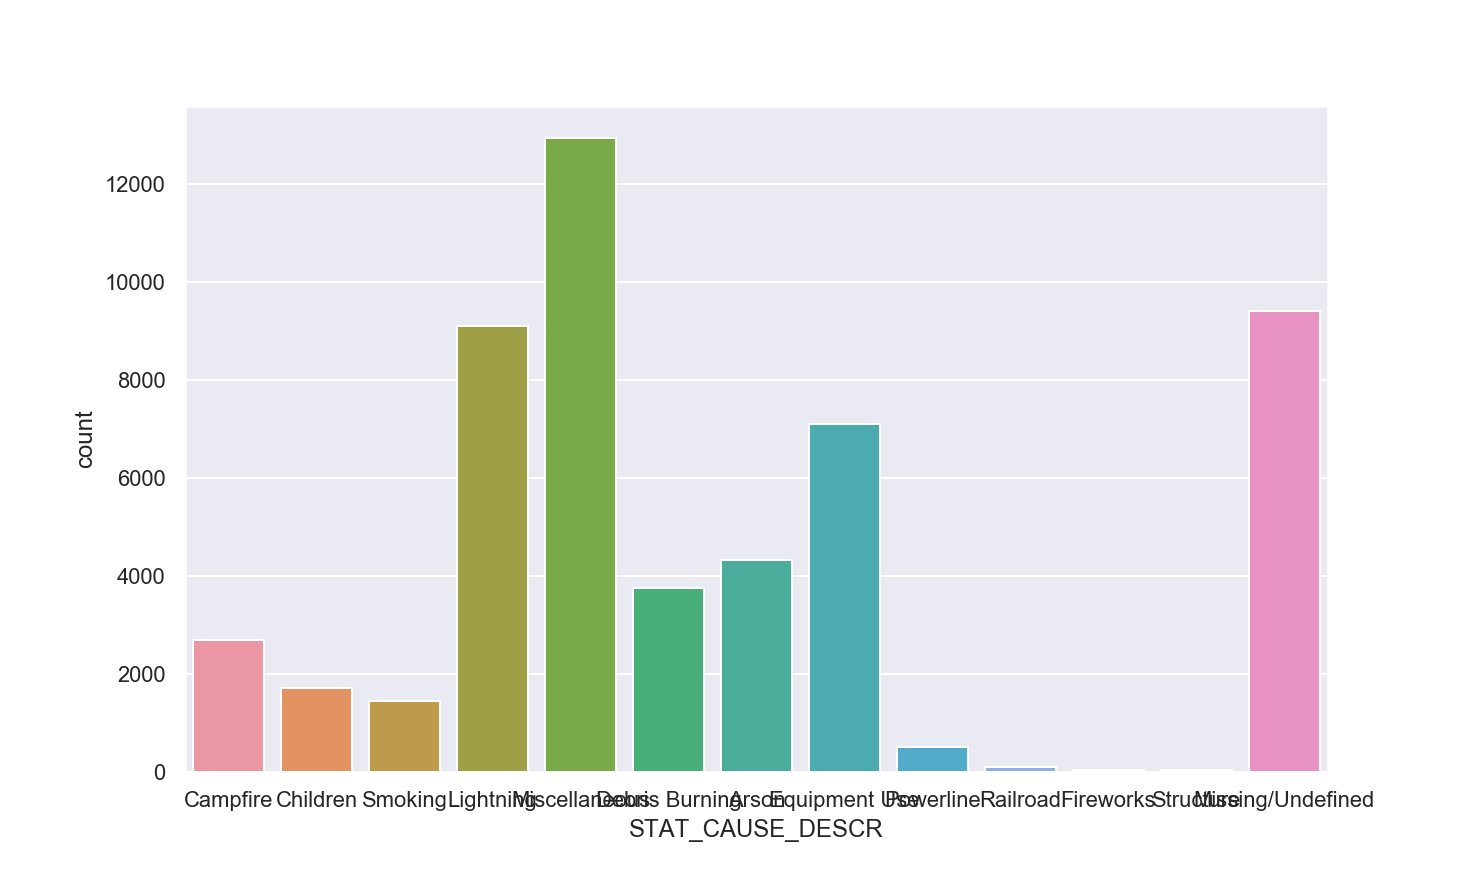

In [362]:
# causes by count - unbalanced data
sns.countplot(x='STAT_CAUSE_DESCR', data=cali)

In [ ]:
# features to drop
drop_vars = ['ID','SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'FIRE_CODE', 'DISCOVERY_DATE',
             'DISCOVERY_TIME','OWNER_CODE', 'FIPS_CODE', 'FIPS_NAME', 'DATE',
            'CONT_DATE', 'CONT_DOY', 'CONT_TIME','FIRE_SIZE_CLASS', 'OWNER_CODE', 'OWNER_DESCR', 
             'STATE', 'FIPS_CODE','NEAR_FID', 'County', 'MONTH','DISCOVERY_DOY', 'FIRE_NAME', 'EMXP', 'EMXT', 'TMIN', 'TMAX']

In [283]:
cali.columns

Index(['ID', 'LATITUDE', 'LONGITUDE', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'FIRE_CODE', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE',
       'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'FIPS_CODE',
       'FIPS_NAME', 'County', 'DATE', 'AWND', 'DX90', 'EMXP', 'EMXT', 'PRCP',
       'TAVG', 'TMAX', 'TMIN', 'NEAR_FID', 'NEAR_DIST', 'MONTH', 'BURN_TIME',
       'cause_label'],
      dtype='object')

In [287]:
# pick relevant features
class_feats = ['LATITUDE', 'LONGITUDE','FIRE_YEAR', 'FIRE_SIZE', 'AWND', 'DX90','PRCP','TAVG', 'NEAR_DIST','BURN_TIME']

# split data
X_class,y_class = cali[class_feats], cali['cause_label']

trainXc, testXc, trainYc, testYc = train_test_split(X_class,y_class, train_size=0.8, random_state=42, shuffle=True)

In [288]:
# scale data
class_scale = StandardScaler()
class_scale.fit(trainXc)

trainX_scalec = class_scale.transform(trainXc)
testX_scalec = class_scale.transform(testXc)

In [291]:
# look at multiple classifier metrics - RF
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

rfc =RandomForestClassifier(random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(trainX_scalec, trainYc)

rfc_train = rfc.predict(trainX_scalec)

print('Train Metrics:\n',metrics.classification_report(trainYc, rfc_train))

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Train Metrics:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      7268
           1       0.96      0.97      0.97      5668
           2       0.97      0.94      0.95      1176
           3       0.98      0.97      0.97      2154
           4       0.98      0.98      0.98      3009
           5       0.99      0.93      0.96        72
           6       0.97      0.95      0.96      3440
           7       0.97      0.94      0.95      1362
           8       0.97      0.97      0.97     10373
           9       1.00      0.75      0.86        20
          10       0.97      0.93      0.95       408
          11       1.00      1.00      1.00        24
          12       0.98      0.99      0.99      7528

    accuracy                           0.97     42502
   macro avg       0.98      0.95      0.96     42502
weighted avg       0.97      0.97      0.97     42502



In [294]:
# RF - cv
rf1_val_scores = cross_validate(rfc, trainX_scalec, trainYc, scoring=scoring, cv=5)

print('Cross validation metrics')
print('Average validation accuracy: ', rf1_val_scores['test_accuracy'].mean())
print('Average validation precision: ', rf1_val_scores['test_precision_macro'].mean())
print('Average validation recall: ', rf1_val_scores['test_recall_macro'].mean())
print('Average validation F1 score: ', rf1_val_scores['test_f1_macro'].mean())

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels wi

Cross validation metrics
Average validation accuracy:  0.41819199612847735
Average validation precision:  0.2831999245468481
Average validation recall:  0.24158833691263265
Average validation F1 score:  0.2495497118631953


Test Accuracy:  0.4077733860342556
Test Metrics:
               precision    recall  f1-score   support

           0       0.65      0.76      0.70      1827
           1       0.30      0.30      0.30      1429
           2       0.16      0.11      0.13       276
           3       0.39      0.34      0.36       530
           4       0.26      0.23      0.24       749
           5       0.17      0.03      0.06        30
           6       0.28      0.22      0.25       881
           7       0.10      0.06      0.08       340
           8       0.36      0.38      0.37      2576
           9       0.00      0.00      0.00         8
          10       0.15      0.07      0.09       103
          11       0.00      0.00      0.00         6
          12       0.44      0.50      0.47      1871

    accuracy                           0.41     10626
   macro avg       0.25      0.23      0.23     10626
weighted avg       0.39      0.41      0.40     10626



<IPython.core.display.Javascript object>


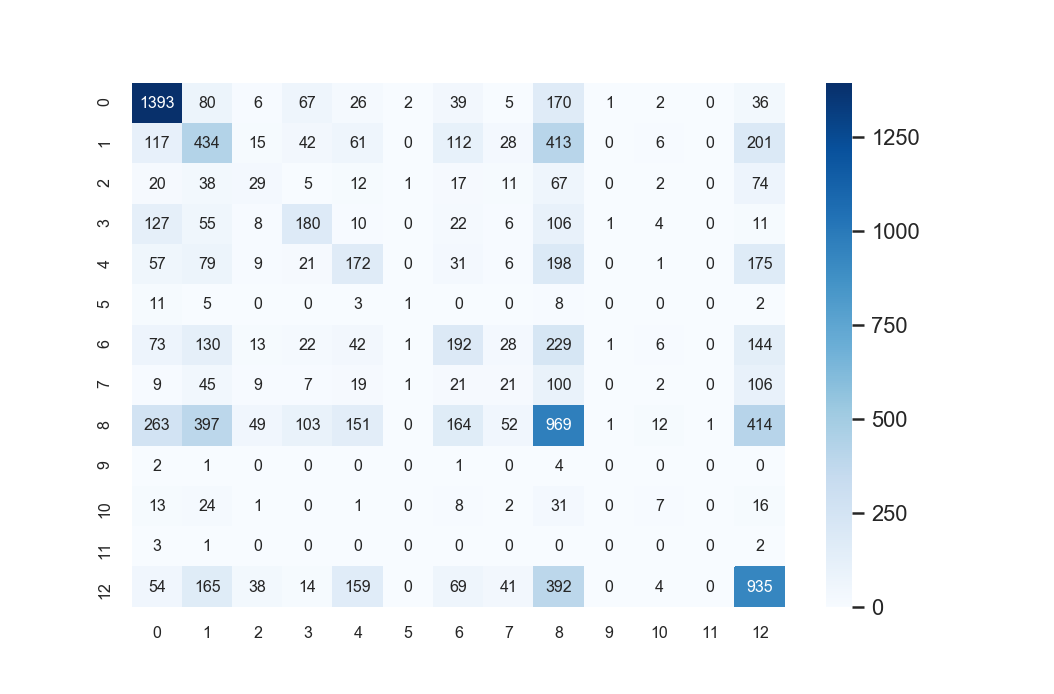

In [296]:
# seems like lightning has best potential with this feature set
rf1_te_preds = rfc.predict(testX_scalec)
print('Test Accuracy: ', metrics.accuracy_score(testYc, rf1_te_preds))
print('Test Metrics:\n',metrics.classification_report(testYc, rf1_te_preds))

sns.heatmap(metrics.confusion_matrix(testYc, rf1_te_preds), annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

We see that the lightning class had the highest predictive potential, followed by missing and miscellaneous (makes sense since highest counts and weather conditions). We will explore predicting lightning caused fires.

#### Binary - Lightning
We get high accuracy, precision, recall when predicting lightning fires using the dataset - we balanced the data set prior

In [297]:
# predict lightning 
cali_cause = cali.copy()
cali_cause.head()

,ID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,...,EMXT,PRCP,TAVG,TMAX,TMIN,NEAR_FID,NEAR_DIST,MONTH,BURN_TIME,cause_label
0,128764,38.900278,-120.002500,FED,FS-FIRESTAT,8525,WAGON,2000,2000/07/03 00:00:00+00,185,...,91.0,11.85,44.0,59.5,28.5,1759,1702.002813,7,1,3
1,128765,38.893889,-120.032222,FED,FS-FIRESTAT,8527,FALLEN,2000,2000/07/07 00:00:00+00,189,...,91.0,11.85,44.0,59.5,28.5,1450,844.446657,7,1,3
2,128766,38.900000,-119.983333,FED,FS-FIRESTAT,8514,HOSPITAL,2000,2000/05/02 00:00:00+00,123,...,91.0,11.85,44.0,59.5,28.5,99,1141.746990,5,1,7
3,128767,39.016944,-120.125000,FED,FS-FIRESTAT,8518,SIERRA,2000,2000/06/15 00:00:00+00,167,...,91.0,11.85,44.0,59.5,28.5,172,2029.504605,6,1,2
4,128768,38.851389,-119.968333,FED,FS-FIRESTAT,8528,ONEIDAS III,2000,2000/07/03 00:00:00+00,185,...,91.0,11.85,44.0,59.5,28.5,1868,4435.980601,7,1,3


In [298]:
cali_cause['LIGHTNING'] = cali_cause['STAT_CAUSE_DESCR'].apply(lambda x: 1 if x == 'Lightning' else 0)
cali_cause.head()

,ID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,...,PRCP,TAVG,TMAX,TMIN,NEAR_FID,NEAR_DIST,MONTH,BURN_TIME,cause_label,LIGHTNING
0,128764,38.900278,-120.002500,FED,FS-FIRESTAT,8525,WAGON,2000,2000/07/03 00:00:00+00,185,...,11.85,44.0,59.5,28.5,1759,1702.002813,7,1,3,0
1,128765,38.893889,-120.032222,FED,FS-FIRESTAT,8527,FALLEN,2000,2000/07/07 00:00:00+00,189,...,11.85,44.0,59.5,28.5,1450,844.446657,7,1,3,0
2,128766,38.900000,-119.983333,FED,FS-FIRESTAT,8514,HOSPITAL,2000,2000/05/02 00:00:00+00,123,...,11.85,44.0,59.5,28.5,99,1141.746990,5,1,7,0
3,128767,39.016944,-120.125000,FED,FS-FIRESTAT,8518,SIERRA,2000,2000/06/15 00:00:00+00,167,...,11.85,44.0,59.5,28.5,172,2029.504605,6,1,2,0
4,128768,38.851389,-119.968333,FED,FS-FIRESTAT,8528,ONEIDAS III,2000,2000/07/03 00:00:00+00,185,...,11.85,44.0,59.5,28.5,1868,4435.980601,7,1,3,0


<IPython.core.display.Javascript object>


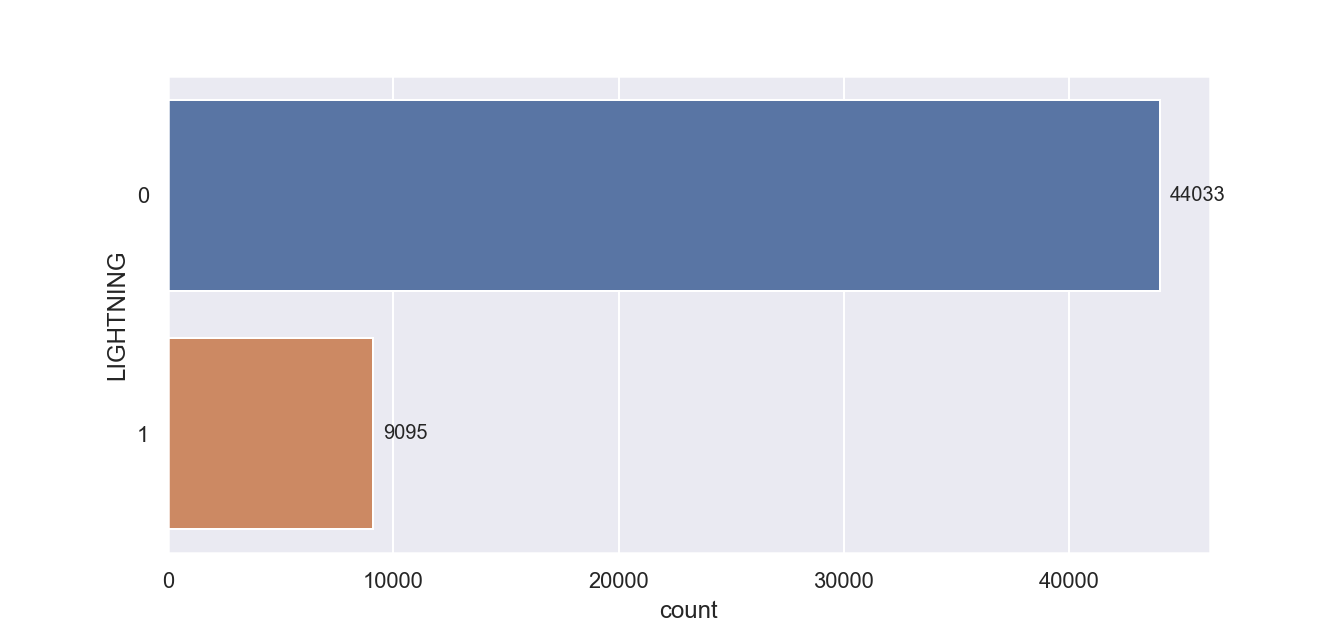

In [299]:
# visualize counts
ax=sns.countplot(y="LIGHTNING", data=cali_cause);
for p in ax.patches:
    ax.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

In [300]:
from sklearn.utils import resample
# balance
# https://elitedatascience.com/imbalanced-classes

df_majority = cali_cause[cali_cause.LIGHTNING==0]
df_minority = cali_cause[cali_cause.LIGHTNING==1]


df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=9095,     # to match minority class
                                 random_state=123)


df_balance = pd.concat([df_majority_downsampled, df_minority])
df_balance['LIGHTNING'].value_counts()

1    9095
0    9095
Name: LIGHTNING, dtype: int64

In [301]:
# preview balanced data
df_balance.head()

,ID,LATITUDE,LONGITUDE,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,...,PRCP,TAVG,TMAX,TMIN,NEAR_FID,NEAR_DIST,MONTH,BURN_TIME,cause_label,LIGHTNING
32724,1615529,37.083611,-121.101389,NONFED,ST-NASF,NaN,ROMERO,2012,2012/09/04 00:00:00+00,248,...,10.36,63.9,78.0,49.8,1780,4400.221210,9,-1346716799999999999,12,0
41160,1653866,39.879250,-122.200267,NONFED,ST-NASF,NaN,LIBERAL,2013,2013/09/06 00:00:00+00,249,...,5.41,64.3,78.4,50.3,2143,5614.307163,9,1,2,0
13447,313424,38.073139,-120.403686,FED,DOI-WFMI,D44Z,UNNAMED FIRE 1741,2007,2007/06/20 00:00:00+00,171,...,21.34,55.3,68.0,42.5,1945,4176.415819,6,1,7,0
42174,1772126,37.792214,-122.226187,NONFED,ST-NASF,NaN,NaN,2014,2014/07/05 00:00:00+00,186,...,14.65,63.8,76.9,50.8,304,5925.781667,7,-1404518399999999999,6,0
21624,1512948,38.762351,-121.331546,NONFED,ST-NASF,NaN,NaN,2011,2011/08/01 00:00:00+00,213,...,53.58,41.4,48.1,34.6,2536,573.300581,8,-1312156799999999999,6,0


In [302]:
# keep relevant features
class_feats = ['LATITUDE', 'LONGITUDE','FIRE_YEAR', 'FIRE_SIZE', 'AWND', 'DX90','PRCP','TAVG', 'NEAR_DIST','BURN_TIME']

# split data
X_light, y_light = df_balance[class_feats], df_balance['LIGHTNING']

trainXL, testXL, trainYL, testYL = train_test_split(X_light, y_light, train_size=0.8, random_state=42, shuffle=True)

In [303]:
# scale data
light_scale = StandardScaler()
light_scale.fit(trainXL)

trainXL_scale = light_scale.transform(trainXL)
testXL_scale = light_scale.transform(testXL)

In [304]:
trainXL.columns

Index(['LATITUDE', 'LONGITUDE', 'FIRE_YEAR', 'FIRE_SIZE', 'AWND', 'DX90',
       'PRCP', 'TAVG', 'NEAR_DIST', 'BURN_TIME'],
      dtype='object')

In [306]:
# logistic regression
log_light = LogisticRegression(solver='lbfgs', random_state=21)
log_light.fit(trainXL_scale, trainYL)

log_tr_preds = log_light.predict(trainXL_scale)
log_te_preds = log_light.predict(testXL_scale)

print('Train: ', metrics.classification_report(trainYL, log_tr_preds))

Train:                precision    recall  f1-score   support

           0       0.79      0.81      0.80      7246
           1       0.81      0.78      0.80      7306

    accuracy                           0.80     14552
   macro avg       0.80      0.80      0.80     14552
weighted avg       0.80      0.80      0.80     14552



In [307]:
# logistic regression - cross validation
log_val_scores = cross_validate(log_light, trainXL_scale, trainYL, scoring=scoring, cv=5)

print('Cross validation metrics')
print('Average validation accuracy: ', log_val_scores['test_accuracy'].mean())
print('Average validation precision: ', log_val_scores['test_precision_macro'].mean())
print('Average validation recall: ', log_val_scores['test_recall_macro'].mean())
print('Average validation F1 score: ', log_val_scores['test_f1_macro'].mean())

Cross validation metrics
Average validation accuracy:  0.796040510177108
Average validation precision:  0.7962922472426582
Average validation recall:  0.7960869268108224
Average validation F1 score:  0.7960111449899652


Test:                precision    recall  f1-score   support

           0       0.80      0.80      0.80      1849
           1       0.80      0.79      0.80      1789

    accuracy                           0.80      3638
   macro avg       0.80      0.80      0.80      3638
weighted avg       0.80      0.80      0.80      3638



<IPython.core.display.Javascript object>


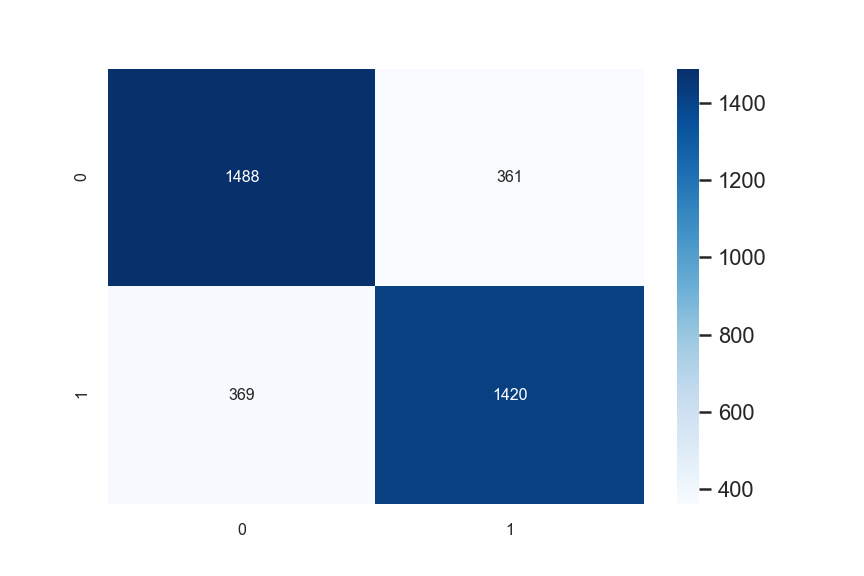

In [308]:
# logistic regression - test
print('Test: ', metrics.classification_report(testYL, log_te_preds))
sns.heatmap(metrics.confusion_matrix(testYL, log_te_preds), annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

In [354]:
# print logistic test metrics
print('Test Accuracy: ', metrics.accuracy_score(testYL, log_te_preds))
print('Test Precision: ', metrics.precision_score(testYL, log_te_preds))
print('Test Recall: ', metrics.recall_score(testYL, log_te_preds))

Test Accuracy:  0.7993402968664101
Test Precision:  0.7973048848961257
Test Recall:  0.7937395192845165


#### Random Forest

/Users/suryamenon/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Train:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      7246
           1       1.00      0.99      0.99      7306

    accuracy                           0.99     14552
   macro avg       0.99      0.99      0.99     14552
weighted avg       0.99      0.99      0.99     14552

Cross validation metrics
Average validation accuracy:  0.8525288414334806
Average validation precision:  0.8528404738161856
Average validation recall:  0.852584710969316
Average validation F1 score:  0.8525072633696237
Test:                precision    recall  f1-score   support

           0       0.85      0.87      0.86      1849
           1       0.86      0.84      0.85      1789

    accuracy                           0.86      3638
   macro avg       0.86      0.86      0.86      3638
weighted avg       0.86      0.86      0.86      3638



<IPython.core.display.Javascript object>


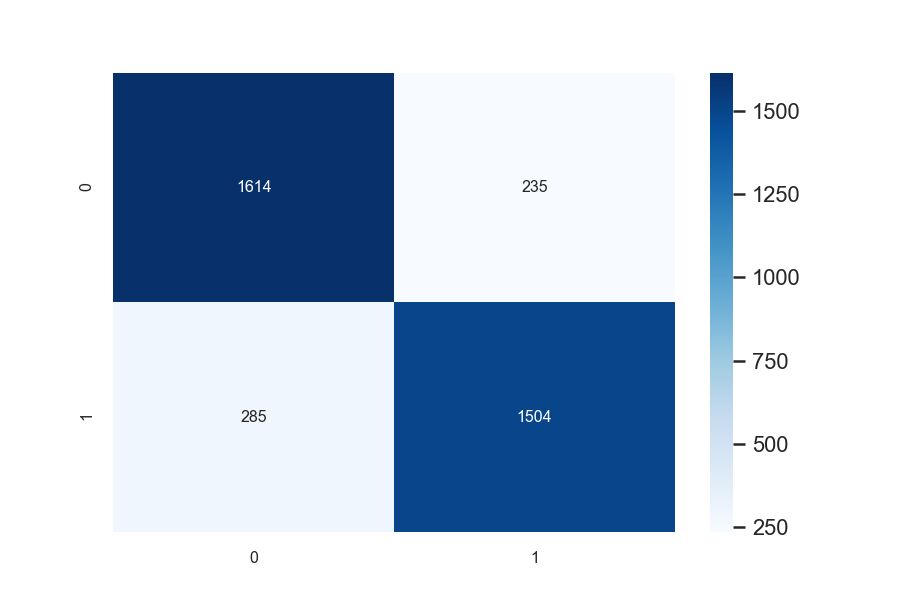

In [309]:
# rf - intial fit
rfc_light =RandomForestClassifier(random_state=42)

rfc_light.fit(trainXL_scale, trainYL)

rfl_tr_preds = rfc_light.predict(trainXL_scale)
rfl_te_preds = rfc_light.predict(testXL_scale)

print('Train: ', metrics.classification_report(trainYL, rfl_tr_preds))

rfl_val_scores = cross_validate(rfc_light, trainXL_scale, trainYL, scoring=scoring, cv=5)

print('Cross validation metrics')
print('Average validation accuracy: ', rfl_val_scores['test_accuracy'].mean())
print('Average validation precision: ', rfl_val_scores['test_precision_macro'].mean())
print('Average validation recall: ', rfl_val_scores['test_recall_macro'].mean())
print('Average validation F1 score: ', rfl_val_scores['test_f1_macro'].mean())

print('Test: ', metrics.classification_report(testYL, rfl_te_preds))
sns.heatmap(metrics.confusion_matrix(testYL, rfl_te_preds), annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

In [315]:
# rf tuning
light_rf_params = {'n_estimators': [10, 50, 89, 100, 200], 
                  'max_features': ['auto', 'sqrt', 'log2', None], 
                  'max_depth': [5,6,8,10, None]}

light_rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=light_rf_params,
                                   cv=5, random_state=2,return_train_score=True)
light_rf_search.fit(trainXL_scale, trainYL)

print("Best Hyperparameters:",light_rf_search.best_params_)
print("Best CV score is {}".format(light_rf_search.best_score_))

Best Hyperparameters: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': None}
Best CV score is 0.8658603628367235


Test:                precision    recall  f1-score   support

           0       0.88      0.86      0.87      1849
           1       0.86      0.88      0.87      1789

    accuracy                           0.87      3638
   macro avg       0.87      0.87      0.87      3638
weighted avg       0.87      0.87      0.87      3638



<IPython.core.display.Javascript object>


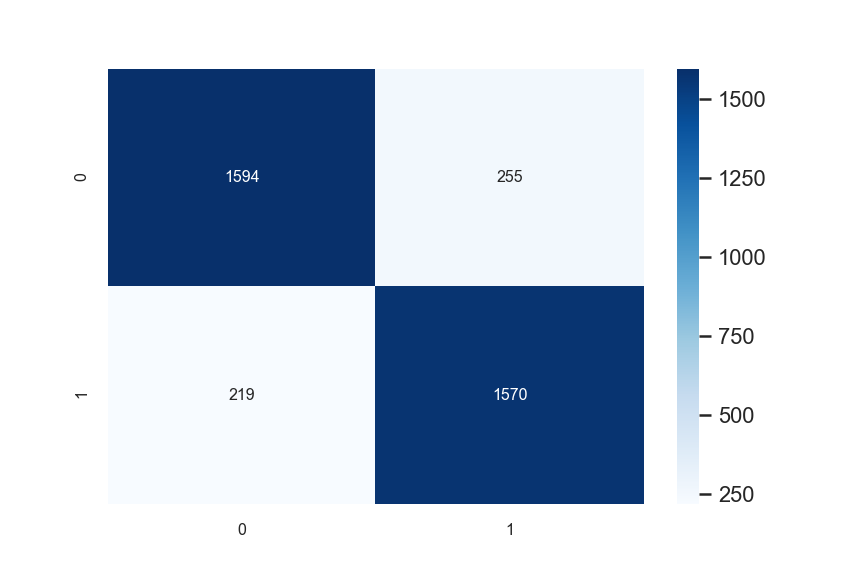

In [317]:
# random forest - test on best estimator 
rf_tune_test = light_rf_search.best_estimator_.predict(testXL_scale)
print('Test: ', metrics.classification_report(testYL, rf_tune_test))
sns.heatmap(metrics.confusion_matrix(testYL, rf_tune_test), annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

<IPython.core.display.Javascript object>


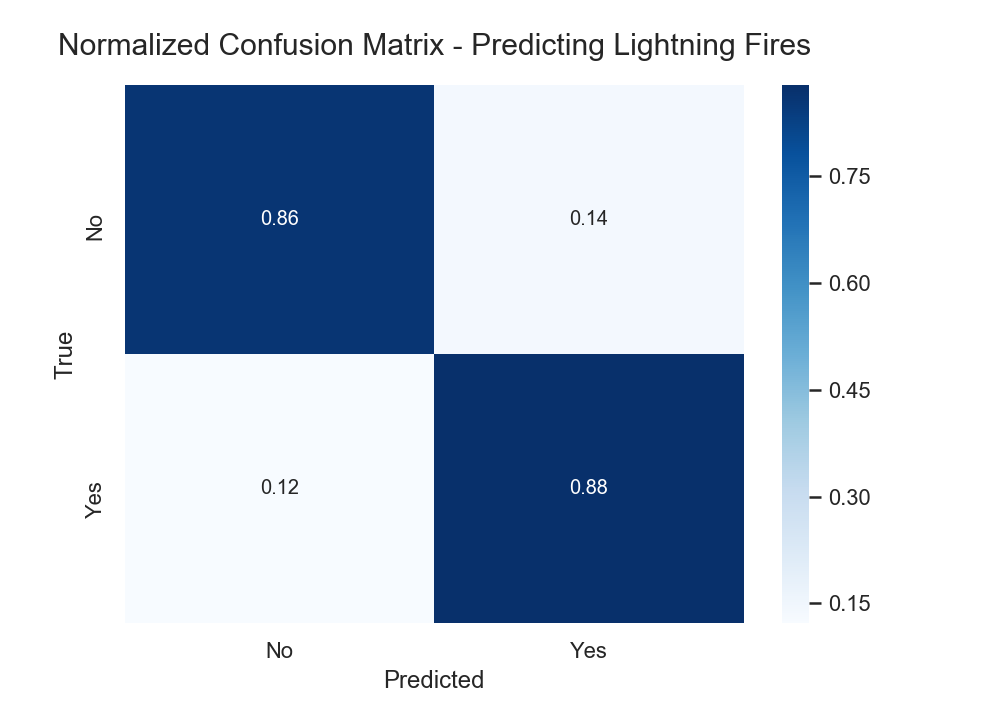

In [336]:
# random forest confusion matrix - normalized
cm_rf = metrics.confusion_matrix(testYL, rf_tune_test)
cm_rf_norm = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
ax=sns.heatmap(cm_rf_norm, annot=True, cmap="Blues", annot_kws={"fontsize":10})
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Normalized Confusion Matrix - Predicting Lightning Fires', fontsize=15, pad=15)
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes']);

In [316]:
# try with 1000 estimators
rf_val2 = cross_validate(RandomForestClassifier(n_estimators=1000,random_state=42), 
                          trainXL_scale, trainYL, scoring=scoring, cv=5)

print('Cross validation metrics')
print('Average validation accuracy: ', rf_val2['test_accuracy'].mean())
print('Average validation precision: ', rf_val2['test_precision_macro'].mean())
print('Average validation recall: ', rf_val2['test_recall_macro'].mean())
print('Average validation F1 score: ', rf_val2['test_f1_macro'].mean())

Cross validation metrics
Average validation accuracy:  0.8650353083342773
Average validation precision:  0.8651199541112687
Average validation recall:  0.8650188513289807
Average validation F1 score:  0.8650217008318171


In [355]:
# print RF best estimator test metrics
print('Test Accuracy: ', metrics.accuracy_score(testYL, rf_tune_test))
print('Test Precision: ', metrics.precision_score(testYL, rf_tune_test))
print('Test Recall: ', metrics.recall_score(testYL, rf_tune_test))

Test Accuracy:  0.8697086311159978
Test Precision:  0.8602739726027397
Test Recall:  0.8775852431525992


#### XGBoost

Train:                precision    recall  f1-score   support

           0       0.95      0.94      0.95      7246
           1       0.94      0.95      0.95      7306

    accuracy                           0.95     14552
   macro avg       0.95      0.95      0.95     14552
weighted avg       0.95      0.95      0.95     14552

Cross validation metrics
Average validation accuracy:  0.870808173784978
Average validation precision:  0.8709118955316075
Average validation recall:  0.8707804854759846
Average validation F1 score:  0.8707910457094036
Test:                precision    recall  f1-score   support

           0       0.89      0.87      0.88      1849
           1       0.87      0.88      0.88      1789

    accuracy                           0.88      3638
   macro avg       0.88      0.88      0.88      3638
weighted avg       0.88      0.88      0.88      3638



<IPython.core.display.Javascript object>


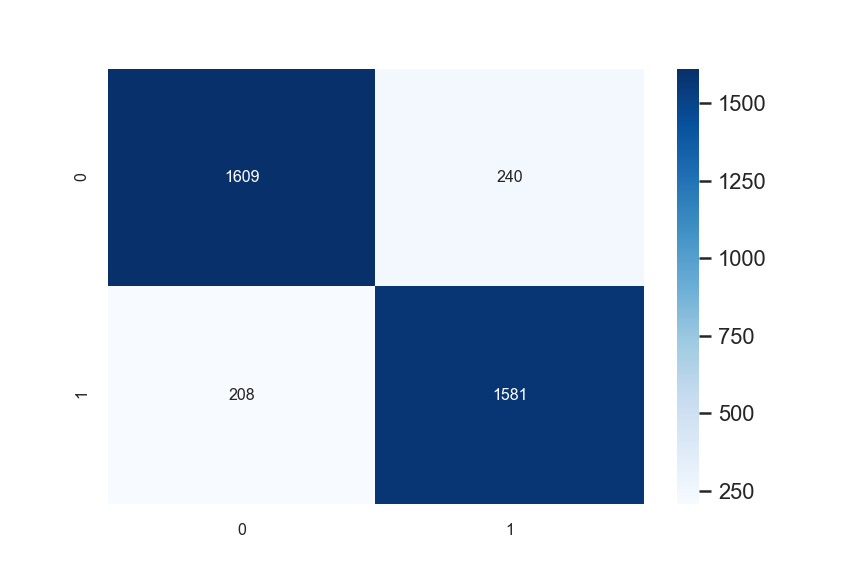

In [310]:
# xgboost
xgb_light =xgb.XGBClassifier(random_state=42)

xgb_light.fit(trainXL_scale, trainYL)

xgbl_tr_preds = xgb_light.predict(trainXL_scale)
xgbl_te_preds = xgb_light.predict(testXL_scale)

print('Train: ', metrics.classification_report(trainYL, xgbl_tr_preds))

xgbl_val_scores = cross_validate(xgb_light, trainXL_scale, trainYL, scoring=scoring, cv=5)

print('Cross validation metrics')
print('Average validation accuracy: ', xgbl_val_scores['test_accuracy'].mean())
print('Average validation precision: ', xgbl_val_scores['test_precision_macro'].mean())
print('Average validation recall: ', xgbl_val_scores['test_recall_macro'].mean())
print('Average validation F1 score: ', xgbl_val_scores['test_f1_macro'].mean())

print('Test: ', metrics.classification_report(testYL, xgbl_te_preds))
sns.heatmap(metrics.confusion_matrix(testYL, xgbl_te_preds), annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

<IPython.core.display.Javascript object>


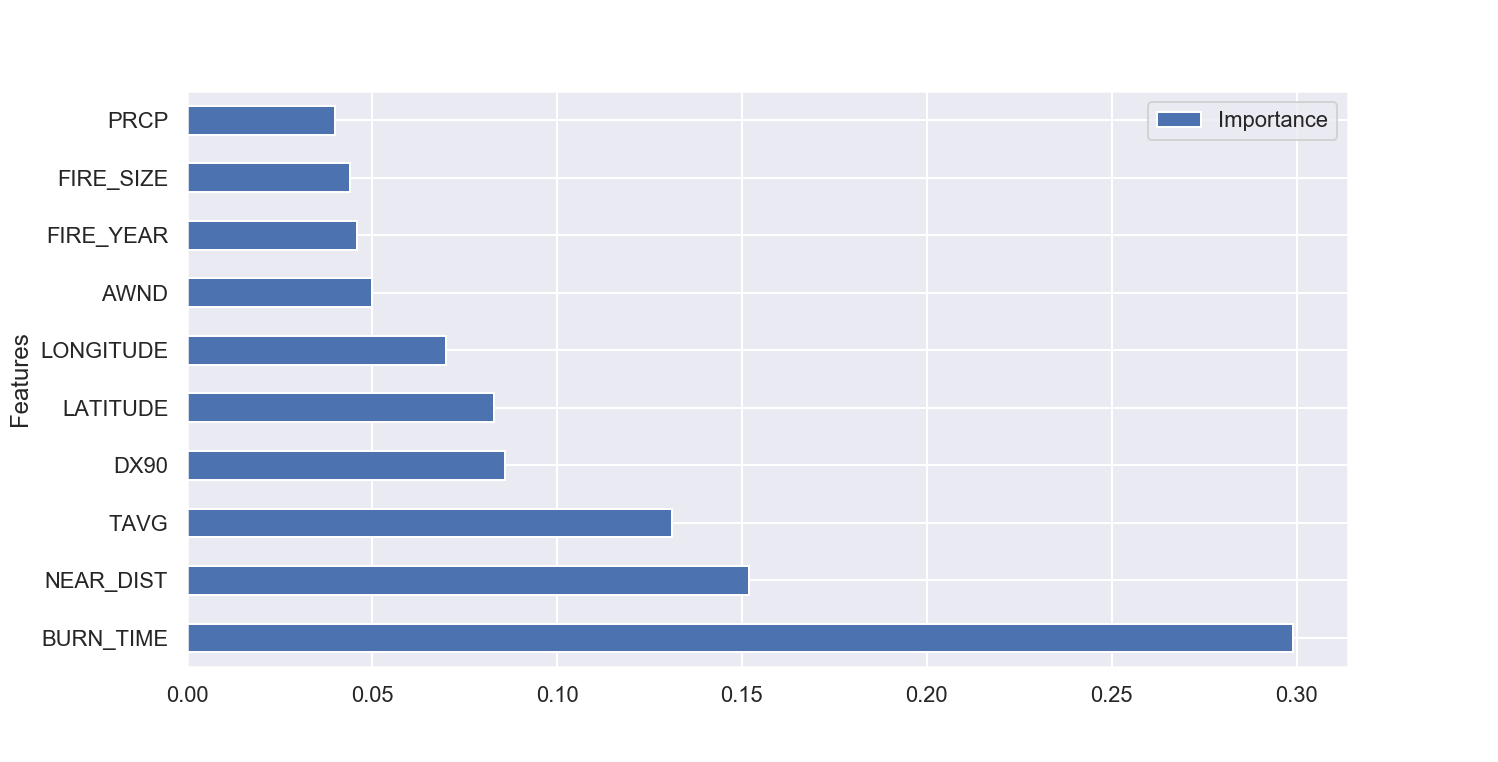

In [313]:
# feature importance
xgb_light_if = pd.DataFrame({'Features':trainXL.columns,'Importance':np.round(xgb_light.feature_importances_,3)}).sort_values('Importance',ascending=False)
xgb_light_if.plot(x='Features',y='Importance',kind='barh');

<IPython.core.display.Javascript object>


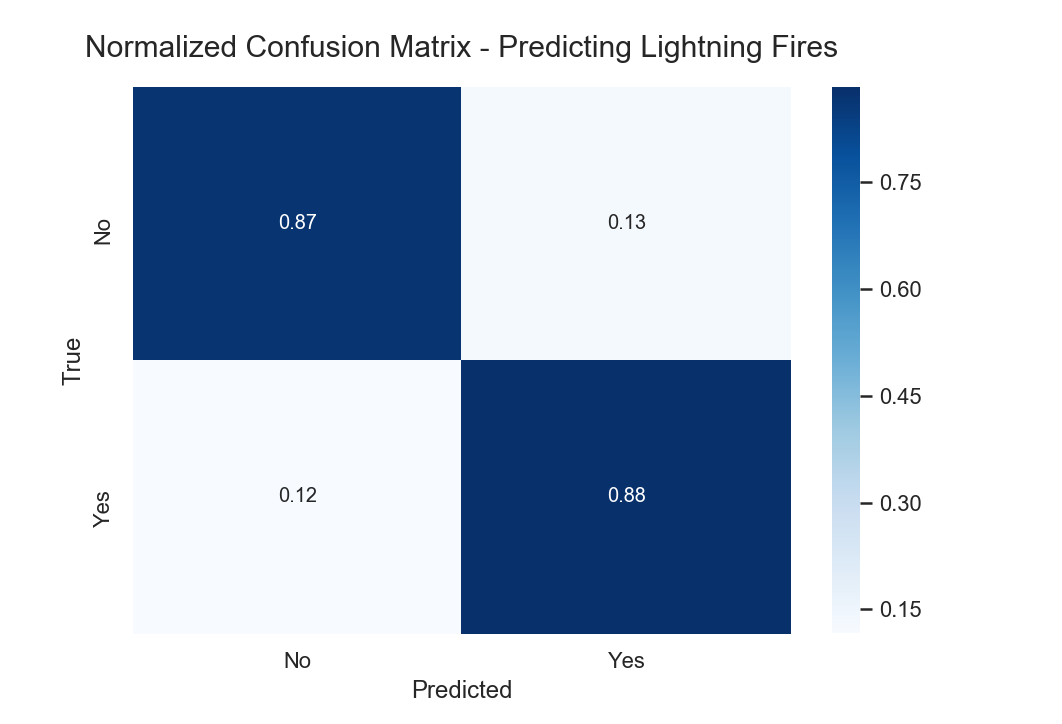

In [338]:
# xgb normalized confusion matrix
cm_xgb = metrics.confusion_matrix(testYL, xgbl_te_preds)
cm_xgb_norm = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]
ax=sns.heatmap(cm_xgb_norm, annot=True, cmap="Blues", annot_kws={"fontsize":10})
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Normalized Confusion Matrix - Predicting Lightning Fires', fontsize=15, pad=15)
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes']);

In [339]:
# xgb tuning
light_xgb_params = {'n_estimators': [100, 300, 500, 1000], 
                  'max_depth': [3, 6, 9, 10]}

light_xgb_search = RandomizedSearchCV(xgb.XGBClassifier(random_state=42), param_distributions=light_xgb_params,
                                   cv=5, random_state=2,return_train_score=True)
light_xgb_search.fit(trainXL_scale, trainYL)

print("Best Hyperparameters:",light_xgb_search.best_params_)
print("Best CV score is {}".format(light_xgb_search.best_score_))

Best Hyperparameters: {'n_estimators': 100, 'max_depth': 10}
Best CV score is 0.872526113249038


Test:                precision    recall  f1-score   support

           0       0.89      0.87      0.88      1849
           1       0.87      0.89      0.88      1789

    accuracy                           0.88      3638
   macro avg       0.88      0.88      0.88      3638
weighted avg       0.88      0.88      0.88      3638



<IPython.core.display.Javascript object>


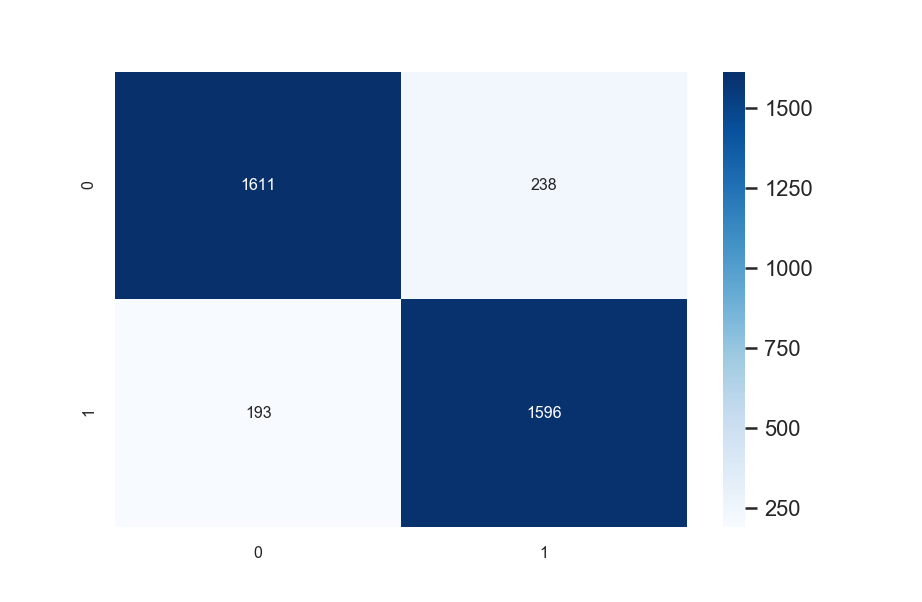

In [340]:
# xgb best estimator test 
xgb_tune_test = light_xgb_search.best_estimator_.predict(testXL_scale)
print('Test: ', metrics.classification_report(testYL, xgb_tune_test))
sns.heatmap(metrics.confusion_matrix(testYL, xgb_tune_test), annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

<IPython.core.display.Javascript object>


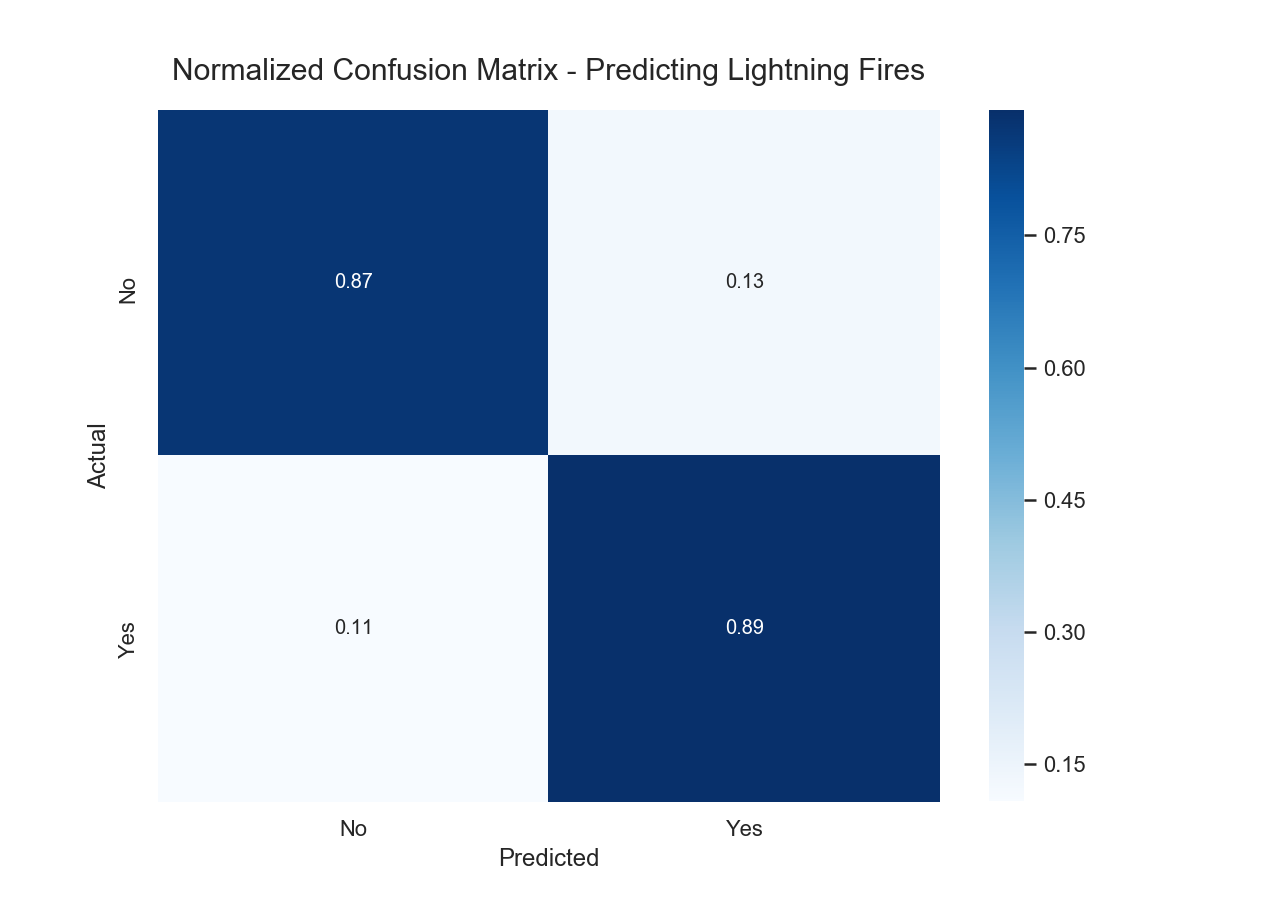

In [361]:
# xgb - tune confusion matrix
cm_xgb2 = metrics.confusion_matrix(testYL, xgb_tune_test)
cm_xgb_norm2 = cm_xgb2.astype('float') / cm_xgb2.sum(axis=1)[:, np.newaxis]
ax=sns.heatmap(cm_xgb_norm2, annot=True, cmap="Blues", annot_kws={"fontsize":10})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Normalized Confusion Matrix - Predicting Lightning Fires', fontsize=15, pad=15)
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes']);

<IPython.core.display.Javascript object>


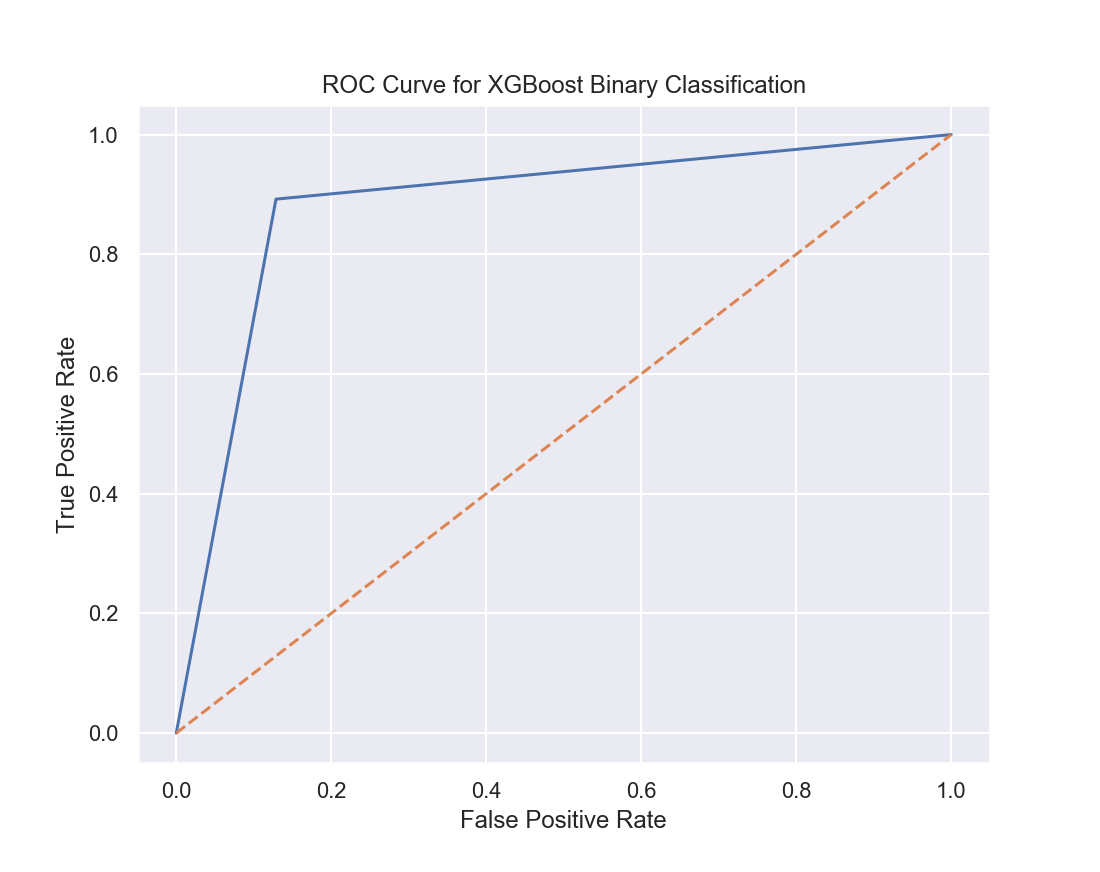

In [342]:
# xgb - test ROC curve
fpr, tpr, _ = metrics.roc_curve(testYL, xgb_tune_test)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title('ROC Curve for XGBoost Binary Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [357]:
# xgb test metrics printed
print('Test Accuracy: ', metrics.accuracy_score(testYL, xgb_tune_test))
print('Test Precision: ', metrics.precision_score(testYL, xgb_tune_test))
print('Test Recall: ', metrics.recall_score(testYL, xgb_tune_test))

Test Accuracy:  0.8815283122594832
Test Precision:  0.8702290076335878
Test Recall:  0.8921185019564002


#### Gradient Boosting

Train:                precision    recall  f1-score   support

           0       0.86      0.86      0.86      7246
           1       0.86      0.86      0.86      7306

    accuracy                           0.86     14552
   macro avg       0.86      0.86      0.86     14552
weighted avg       0.86      0.86      0.86     14552

Cross validation metrics
Average validation accuracy:  0.8496418658660927
Average validation precision:  0.8497137526318527
Average validation recall:  0.8496489533808542
Average validation F1 score:  0.8496341222173287
Test:                precision    recall  f1-score   support

           0       0.86      0.85      0.86      1849
           1       0.85      0.85      0.85      1789

    accuracy                           0.85      3638
   macro avg       0.85      0.85      0.85      3638
weighted avg       0.85      0.85      0.85      3638



<IPython.core.display.Javascript object>


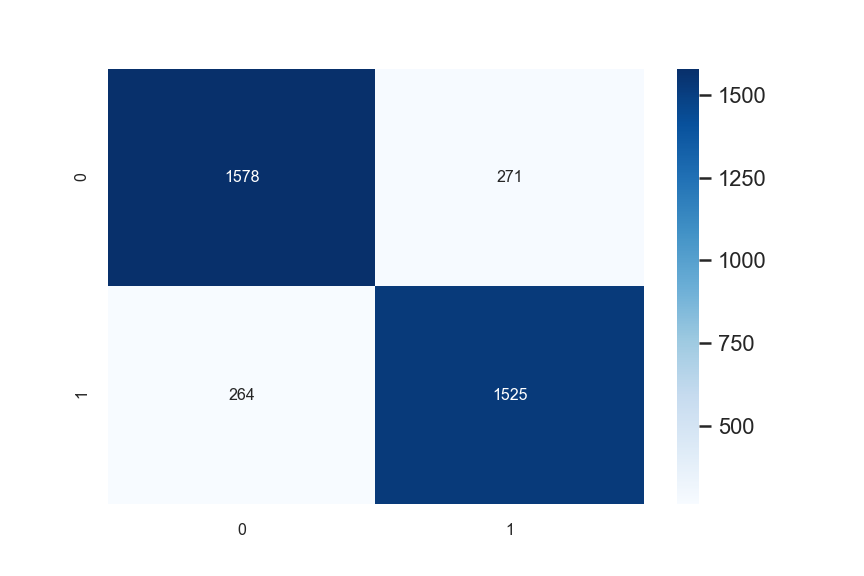

In [312]:
# gradient boost
gb_light =GradientBoostingClassifier(random_state=42)

gb_light.fit(trainXL_scale, trainYL)

gb_tr_preds = gb_light.predict(trainXL_scale)
gb_te_preds = gb_light.predict(testXL_scale)

print('Train: ', metrics.classification_report(trainYL, gb_tr_preds))

gbl_val_scores = cross_validate(gb_light, trainXL_scale, trainYL, scoring=scoring, cv=5)

print('Cross validation metrics')
print('Average validation accuracy: ', gbl_val_scores['test_accuracy'].mean())
print('Average validation precision: ', gbl_val_scores['test_precision_macro'].mean())
print('Average validation recall: ', gbl_val_scores['test_recall_macro'].mean())
print('Average validation F1 score: ', gbl_val_scores['test_f1_macro'].mean())

print('Test: ', metrics.classification_report(testYL, gb_te_preds))
sns.heatmap(metrics.confusion_matrix(testYL, gb_te_preds), annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize":8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);